In [1]:
# # Fix OpenMP library conflicts and other potential issues
import os
import sys
import gc

# Handle OpenMP library conflicts
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# # Limit threading to reduce memory contention
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"
# os.environ["OMP_NUM_THREADS"] = "1"

# # Force PyTorch to use CPU instead of GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# # Enable aggressive garbage collection
# gc.enable()

## 1) Let's make sure we have all our imports.

In [2]:
import numpy as np
import torch
from itertools import product
from typing import Sequence, Tuple, Optional
import time
import pandas as pd
import os
import glob
import math
import matplotlib.pyplot as plt
import json


In [3]:
!pip install rdkit

!pip install tqdm

!pip install scikit-learn

## 2) Utility Functions

In [4]:
################################################################################
# Utility functions
################################################################################

def compute_translation(center: np.ndarray,
                        grid_size: int = 48,
                        voxel_size: float = 1.0) -> np.ndarray:
    """Return the translation vector that places *center* at the grid centre."""
    grid_center = ((grid_size - 1) / 2.0) * voxel_size
    return grid_center - center


def gaussian_kernel(radius: int = 2, sigma: float = 1.0) -> Tuple[np.ndarray, np.ndarray]:
    """Return neighbour offsets and weights for a 3‑D isotropic Gaussian.

    Parameters
    ----------
    radius
        Number of voxels in each direction to include.
    sigma
        Standard deviation (in voxels).

    Returns
    -------
    offsets : (K, 3) int array
        Relative integer offsets.
    weights : (K,) float array
        Corresponding weights ∈ [0, 1].
    """
    offsets = np.array(list(product(range(-radius, radius + 1),
                                    repeat=3)), dtype=np.int8)
    # exclude origin – it is handled separately
    offsets = offsets[(offsets != 0).any(axis=1)]
    distances2 = (offsets ** 2).sum(axis=1).astype(np.float32)
    weights = np.exp(-distances2 / (2 * sigma ** 2))
    return offsets, weights



In [5]:
################################################################################
# Core voxelisation
################################################################################

def voxelise_atoms(atom_coords: np.ndarray,
                   atom_feats: np.ndarray,
                   *,
                   grid_size: int = 48,
                   voxel_size: float = 1.0,
                   centre: Optional[np.ndarray] = None,
                   gaussian_radius: int = 2,
                   gaussian_sigma: float = 1.0
                   ) -> np.ndarray:
    """Convert atomic coordinates + features to a (C, N, N, N) voxel grid.

    Parameters
    ----------
    atom_coords : (N_atoms, 3) float32 array
        Cartesian XYZ coordinates in ångströms.
    atom_feats : (N_atoms, C) float32 array
        Per‑atom feature vectors (same channels *C* for every atom).
    centre
        If *None*, the coordinates’ centroid is used. Otherwise, supply a
        (3,) array – for example, the ligand centroid – that will be mapped
        to the geometric centre of the grid.
    gaussian_radius
        Radius, in voxels, of the isotropic Gaussian used to smooth/distribute
        the signal. Use 0 to disable smoothing.
    gaussian_sigma
        Standard deviation (in voxels) of the Gaussian.

    Returns
    -------
    grid : (C, grid_size, grid_size, grid_size) float32 array
    """
    assert atom_coords.shape[0] == atom_feats.shape[0], "Mismatched atoms/feats"
    C = atom_feats.shape[1]
    grid = np.zeros((C, grid_size, grid_size, grid_size), dtype=np.float32)

    if centre is None:
        centre = atom_coords.mean(axis=0, dtype=np.float32)

    # translate so that *centre* maps to the grid midpoint
    translation = compute_translation(centre, grid_size, voxel_size)
    shifted = atom_coords + translation[None, :]

    # integer voxel indices
    indices = np.floor(shifted / voxel_size).astype(np.int16)  # (N,3)

    # mask atoms that fall outside the grid
    valid = ((indices >= 0) & (indices < grid_size)).all(axis=1)
    indices, feats = indices[valid], atom_feats[valid]

    # pre‑build Gaussian neighbours
    if gaussian_radius > 0:
        neigh_offsets, neigh_weights = gaussian_kernel(gaussian_radius, gaussian_sigma)

    for (x, y, z), f in zip(indices, feats):
        # contribute to the central voxel
        grid[:, x, y, z] += f

        # optionally spread to neighbours
        if gaussian_radius > 0:
            neigh_idx = np.stack([x, y, z]) + neigh_offsets  # (K,3)
            # keep neighbours inside the grid boundaries
            valid_neigh = ((neigh_idx >= 0) & (neigh_idx < grid_size)).all(axis=1)
            neigh_idx = neigh_idx[valid_neigh]
            neigh_w   = neigh_weights[valid_neigh]

            for (nx, ny, nz), w in zip(neigh_idx, neigh_w):
                grid[:, nx, ny, nz] += f * w

    return grid


In [6]:
################################################################################
# Example torch Dataset
################################################################################
import torch
import torch.nn as nn
import torch.nn.functional as F # Import F for functional API like F.mse_loss
from torch.utils.data import DataLoader # Ensure DataLoader is imported here if not already

class VoxelDataset(torch.utils.data.Dataset):
    """Minimal dataset for protein–ligand voxel grids."""

    def __init__(self,
                 complexes: Sequence[Tuple[str, str]], # Add type hints for clarity
                 label_func,
                 cutoff: float = 6.0,
                 grid_size: int = 48,
                 voxel_size: float = 1.0,
                 channels: int = 19 # Set default to 19 as per example
                 ):
        """Parameters
        ----------
        complexes
            Iterable of protein–ligand complexes as tuples of (protein_mol2_path, ligand_mol2_path).
        label_func
            Callable that returns a scalar target given the protein and ligand paths.
        cutoff
            Distance (Å) around the ligand to include protein atoms.
        grid_size : int
            Size of the voxel grid along each dimension.
        voxel_size : float
            Resolution of each voxel in Å.
        channels : int
            Number of feature channels per atom.
        """
        self.complexes   = list(complexes)
        self.label_func  = label_func
        self.cutoff      = cutoff
        self.grid_size   = grid_size
        self.voxel_size  = voxel_size
        self.channels    = channels # Keep channels parameter but use 19 in example

    def _extract_atoms_from_mols(self, protein_mol, protein_conf, ligand_mol, ligand_conf):
        """Return coords and features of atoms within *cutoff* of the ligand."""
        coords, feats = [], []

        # ligand atoms
        # Safely attempt to get ligand atom positions
        try:
            lig_coords = np.array([ligand_conf.GetAtomPosition(i) for i in range(ligand_mol.GetNumAtoms())], dtype=np.float32)
        except Exception as e:
             # Catch potential errors during position retrieval
             print(f"Error extracting ligand positions: {e}. Returning empty arrays.")
             return np.empty((0, 3), dtype=np.float32), np.empty((0, self.channels), dtype=np.float32)


        # Check if lig_coords is empty after creation
        if lig_coords.shape[0] == 0:
            # No ligand atoms found or extracted successfully.
            # Return empty arrays for coords and feats.
            print("No ligand atom coordinates extracted. Returning empty arrays.")
            return np.empty((0, 3), dtype=np.float32), np.empty((0, self.channels), dtype=np.float32)


        # If ligand atoms were extracted, process them
        for i, at in enumerate(ligand_mol.GetAtoms()):
            # Check if the atom index is valid within lig_coords (should be if lig_coords has shape > 0)
            if i < lig_coords.shape[0]:
                 pos = lig_coords[i] # Use the numpy array we already created
                 coords.append(pos)
                 # Pass the atom and molecule type (+1 for ligand)
                 feats.append(atom_to_feature_vec(at, +1))
            else:
                 print(f"Warning: Ligand atom index {i} out of bounds for extracted positions ({lig_coords.shape[0]}). Skipping atom.")


        # protein atoms within *cutoff* Å of any ligand atom
        # Ensure lig_coords_np is used for distance calculation only if it's not empty
        if lig_coords.shape[0] > 0:
             # Ensure lig_coords is a numpy array of float32 (already done above)
             lig_coords_np = lig_coords

             for i, at in enumerate(protein_mol.GetAtoms()):
                 # Safely attempt to get protein atom position
                 try:
                     pos = protein_conf.GetAtomPosition(i)
                     p   = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
                 except Exception as e:
                     print(f"Error extracting protein position for atom {i}: {e}. Skipping atom.")
                     continue # Skip this protein atom


                 # Check distance to any ligand atom ONLY if lig_coords is not empty
                 if np.min(np.linalg.norm(lig_coords_np - p, axis=1)) > self.cutoff:
                     continue
                 coords.append(p)
                 # Pass the atom and molecule type (-1 for protein)
                 feats.append(atom_to_feature_vec(at, -1))
        else:
            print("Ligand coordinates are empty, skipping protein atom distance check.")
            # If ligand coords are empty, no protein atoms within cutoff can exist.
            # The coords and feats lists will only contain ligand atoms (which is zero in this branch).


        return np.asarray(coords, np.float32), np.asarray(feats, np.float32)


    def __len__(self):
        return len(self.complexes)

    def __getitem__(self, idx):
        # comp is a tuple: (protein_mol2_path, ligand_mol2_path)
        prot_path, lig_path = self.complexes[idx]
        print(f"Processing complex: {os.path.basename(os.path.dirname(prot_path))}")

        # Load molecules using the previously defined load_mol2 function
        protein_mol, protein_conf = load_mol2(prot_path)
        ligand_mol, ligand_conf = load_mol2(lig_path)

        # Handle cases where loading failed or no conformer was found
        if protein_mol is None or protein_conf is None or ligand_mol is None or ligand_conf is None:
             print(f"Skipping complex due to loading/conformer error: {prot_path}, {lig_path}")
             # Depending on your needs, you might skip this item,
             # raise an error, or return None/handle it in the DataLoader.
             # For simplicity here, we'll return None and filter later if needed.
             # A more robust approach for DataLoader is to raise an error
             # or return a placeholder that downstream code can handle.
             # Let's raise an error for clarity during debugging.
             return None, None


        # Extract atoms and features from the loaded molecules
        coords, feats = self._extract_atoms_from_mols(protein_mol, protein_conf, ligand_mol, ligand_conf)

        # Check if _extract_atoms_from_mols returned empty arrays
        if coords.shape[0] == 0:
             print(f"Skipping complex due to no atoms extracted: {prot_path}, {lig_path}")
             return None, None

        # Calculate centre on ligand centroid for robustness
        # Use the loaded ligand conformer's atom positions
        ligand_atom_coords = np.array([ligand_conf.GetAtomPosition(i) for i in range(ligand_mol.GetNumAtoms())], dtype=np.float32)
        centre = np.mean(ligand_atom_coords, axis=0, dtype=np.float32)


        # Voxelise atoms
        grid = voxelise_atoms(coords, feats,
                              grid_size=self.grid_size,
                              voxel_size=self.voxel_size,
                              centre=centre)

        # convert to torch tensors
        grid  = torch.from_numpy(grid)
        # Call label_func with the paths, as defined in your example
        label = torch.tensor(self.label_func(prot_path, lig_path), dtype=torch.float32)

        # print("Shape of the grid:", grid.shape)

        return grid, label

In [7]:
# ----------------------------------------------------------
# 1.  Imports & constants
# ----------------------------------------------------------
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

# 19-channel layout ------------------------------------------------------------
#  0-8 : one-hot element   (B, C, N, O, P, S, Se, halogen, metal)
#    9 : hybridisation     (1, 2, 3  → sp, sp2, sp3; 0 = “other”)
#   10 : heavy-atom bonds  (# neighbours with Z > 1)
#   11 : hetero-atom bonds (# neighbours with Z not in {1, 6})
# 12-16: one-hot structural (hydrophobic, aromatic, acceptor, donor, ring)
#   17 : partial charge    (Gasteiger)
#   18 : molecule type     (–1 protein, +1 ligand)
# ------------------------------------------------------------------------------
FEATURE_DIM = 19
ELEMENTS     = {5:0, 6:1, 7:2, 8:3, 15:4, 16:5, 34:6}       # explicit slots
HALOGENS     = {9, 17, 35, 53}
# every other Z > 1 that isn’t in ELEMENTS ∪ HALOGENS is considered “metal”

# ----------------------------------------------------------
# 2.  Atom-level feature builder
# ----------------------------------------------------------
def atom_to_feature_vec(atom, mol_type: int) -> np.ndarray:
    """Return a (19,) float32 feature vector for one RDKit atom."""
    vec = np.zeros(FEATURE_DIM, dtype=np.float32)

    # 1) element (9 one-hot channels)
    Z   = atom.GetAtomicNum()
    idx = ELEMENTS.get(Z, 7 if Z in HALOGENS else 8)
    vec[idx] = 1.0                           # channels 0-8

    # 2) hybridisation
    hyb = {Chem.rdchem.HybridizationType.SP: 1,
           Chem.rdchem.HybridizationType.SP2: 2,
           Chem.rdchem.HybridizationType.SP3: 3}.get(atom.GetHybridization(), 0)
    vec[9] = float(hyb)

    # 3) heavy-atom & hetero-atom bond counts
    heavy = hetero = 0
    for b in atom.GetBonds():
        Z_nbr = b.GetOtherAtom(atom).GetAtomicNum()
        if Z_nbr > 1:  heavy += 1
        if Z_nbr not in (1, 6): hetero += 1
    vec[10], vec[11] = float(heavy), float(hetero)

    # 4) structural 5-hot
    vec[12] = 1.0 if Z == 6 and not atom.GetIsAromatic() else 0.0   # hydrophobic
    vec[13] = 1.0 if atom.GetIsAromatic() else 0.0                 # aromatic
    vec[14] = 1.0 if atom.GetTotalNumHs() < atom.GetNumImplicitHs() else 0.0  # acceptor (very rough)
    vec[15] = 1.0 if atom.GetTotalNumHs() > 0 and Z in (7, 8) else 0.0        # donor   (rough)
    vec[16] = 1.0 if atom.IsInRing() else 0.0                                   # ring

    # 5) partial charge (need Gasteiger first)
    charge = 0.0 # Default charge
    if atom.HasProp('_GasteigerCharge'):
        try:
            charge = float(atom.GetProp('_GasteigerCharge'))
        except ValueError:
            print(f"Warning: Could not convert Gasteiger charge to float for atom {atom.GetIdx()} in molecule.")
            charge = 0.0 # Set to 0 if conversion fails

    vec[17] = charge

    # 6) molecule type
    vec[18] = float(mol_type)

    return vec

import os
# ----------------------------------------------------------
# 3.  Convenience loader for .mol2  (+ charges)
# ----------------------------------------------------------
def load_mol2(path):
    if not os.path.exists(path):
        raise RuntimeError(f"File not found: {path}, please upload the file")
    # Load molecule without sanitization initially
    mol = Chem.MolFromMol2File(path, sanitize=False, removeHs=False)

    # Check if the molecule was loaded successfully
    if mol is None:
        print(f"Error loading molecule from {path}")
        return None, None # Return None for both molecule and conformer

    # Sanitize the molecule, excluding Kekulization
    # This is necessary because some protein structures might have unusual bonding that RDKit's Kekulization struggles with.
    # We perform other sanitization steps that are generally safe.
    sanitizeFlags = Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE
    try:
        Chem.SanitizeMol(mol, sanitizeFlags)
    except Exception as e:
        print(f"Error sanitizing molecule from {path}: {e}")
        return None, None # Return None if sanitization fails

    # Compute Gasteiger charges ONLY if mol was loaded and sanitized successfully
    try:
        AllChem.ComputeGasteigerCharges(mol)
    except Exception as e:
        # Gasteiger charge computation can sometimes fail
        print(f"Warning: Could not compute Gasteiger charges for {path}: {e}")
        # We might still return the molecule and conformer even if charges fail,
        # or return None depending on downstream requirements.
        # Returning None might be safer if charges are essential.
        return None, None


    # Get the conformer
    try:
        conformer = mol.GetConformer()
    except ValueError:
        print(f"Error getting conformer from {path}")
        return mol, None # Return molecule but None for conformer if no conformer exists

    return mol, conformer
    # Chem.SanitizeMol(mol, sanitizeFlags)

    # # Compute Gasteiger charges
    # AllChem.ComputeGasteigerCharges(mol)

    # # Get the conformer
    # try:
    #     conformer = mol.GetConformer()
    # except ValueError:
    #     print(f"Error getting conformer from {path}")
    #     return mol, None # Return molecule but None for conformer if no conformer exists

    # return mol, conformer


# ----------------------------------------------------------
# 4.  Collect atoms, build voxel grid
# ----------------------------------------------------------
def complex_to_grid(protein_mol2, ligand_mol2, cutoff=6.0,
                    grid_size=48, voxel=1.0):
    prot, pconf = load_mol2(protein_mol2)
    lig,  lconf = load_mol2(ligand_mol2)

    # ligand centroid (grid centre)
    lig_coords = np.array([lconf.GetAtomPosition(i) for i in range(lig.GetNumAtoms())])
    centre     = lig_coords.mean(axis=0)

    # ligand atoms -------------------------------------------------------------
    coords, feats = [], []
    for i, at in enumerate(lig.GetAtoms()):
        pos = lconf.GetAtomPosition(i)
        coords.append([pos.x, pos.y, pos.z])
        feats.append(atom_to_feature_vec(at, +1))

    # protein atoms within *cutoff* Å of any ligand atom -----------------------
    lig_coords = lig_coords.astype(np.float32)
    for i, at in enumerate(prot.GetAtoms()):
        pos = pconf.GetAtomPosition(i)
        p   = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
        if np.min(np.linalg.norm(lig_coords - p, axis=1)) > cutoff:
            continue
        coords.append(p)
        feats.append(atom_to_feature_vec(at, -1))

    coords = np.asarray(coords, np.float32)
    feats  = np.asarray(feats,  np.float32)

    # -------------------------------------------------------------------------
    # 5.  Voxelise → (19, 48, 48, 48)
    # -------------------------------------------------------------------------
    grid = voxelise_atoms(coords, feats,
                          grid_size=grid_size,
                          voxel_size=voxel,
                          centre=centre)
    return grid


# ----------------------------------------------------------
# 6.  Example usage
# ----------------------------------------------------------


C/19: This is the number of channels or features for each voxel. These 19 channels correspond to different atomic properties, such as:

  * One-hot encoding for elements (B, C, N, O, P, S, Se, halogen, metal)
  * Hybridization
  * Heavy-atom bonds
  * Hetero-atom bonds
  * One-hot structural properties (hydrophobic, aromatic, acceptor,donor, ring)
  * Partial charge (Gasteiger)
  * Molecule type (protein or ligand)

# Improved Protein Spatial Representation System

This section implements a redesigned spatial representation system specifically optimized for protein structures. The system processes all 228 protein structures in the demo_charges folder and creates robust 3D voxel representations suitable for CNN training.

## Key Improvements:
1. **Protein-focused feature engineering** - Optimized feature channels for protein structure analysis
2. **Batch processing** - Efficient handling of all 228 structures
3. **Enhanced error handling** - Robust processing with detailed logging
4. **Modular design** - Separate components for data loading, feature extraction, and voxelization
5. **Data validation** - Quality checks and filtering of problematic structures

In [8]:
################################################################################
# Improved Protein Spatial Representation System
################################################################################

import numpy as np
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Crippen
import os
import glob
from pathlib import Path
import pandas as pd
from typing import List, Tuple, Dict, Optional, Union
import logging
from dataclasses import dataclass
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Enhanced feature configuration for protein analysis
@dataclass
class ProteinFeatureConfig:
    """Configuration for protein feature extraction"""
    # Basic atomic features
    element_types: Dict[int, int] = None
    include_hydrogens: bool = False
    
    # Spatial features
    grid_size: int = 64  # Increased for better resolution
    voxel_size: float = 0.8  # Finer resolution
    cutoff_radius: float = 8.0  # Larger cutoff for protein context
    
    # Gaussian smoothing
    gaussian_radius: int = 2
    gaussian_sigma: float = 1.2
    
    # Feature channels (24 channels for enhanced protein representation)
    feature_dim: int = 24
    
    def __post_init__(self):
        if self.element_types is None:
            # Enhanced element mapping for proteins
            self.element_types = {
                1: 0,   # H - Hydrogen
                6: 1,   # C - Carbon  
                7: 2,   # N - Nitrogen
                8: 3,   # O - Oxygen
                15: 4,  # P - Phosphorus
                16: 5,  # S - Sulfur
                9: 6,   # F - Fluorine
                17: 7,  # Cl - Chlorine
                35: 8,  # Br - Bromine
                53: 9,  # I - Iodine
                # Metals commonly found in proteins
                12: 10, # Mg - Magnesium
                20: 10, # Ca - Calcium  
                25: 10, # Mn - Manganese
                26: 10, # Fe - Iron
                30: 10, # Zn - Zinc
                # Other elements → 11 (other)
            }

# Global configuration
PROTEIN_CONFIG = ProteinFeatureConfig()

In [9]:
def extract_enhanced_protein_features(atom, mol) -> np.ndarray:
    """
    Extract enhanced 24-dimensional feature vector for protein atoms.
    
    Feature channels:
    0-11: Element one-hot (H,C,N,O,P,S,F,Cl,Br,I,metals,other)
    12: Atomic mass (normalized)
    13: Partial charge (Gasteiger)
    14: Van der Waals radius
    15: Electronegativity
    16: Hybridization (sp=1, sp2=2, sp3=3, other=0)
    17: Formal charge
    18: Number of heavy atom neighbors
    19: Number of heteroatom neighbors
    20: Aromaticity (0/1)
    21: In ring (0/1)
    22: Hydrophobic (0/1)
    23: B-factor / flexibility (if available, else 0)
    """
    
    features = np.zeros(PROTEIN_CONFIG.feature_dim, dtype=np.float32)
    
    # Element one-hot encoding (channels 0-11)
    atomic_num = atom.GetAtomicNum()
    element_idx = PROTEIN_CONFIG.element_types.get(atomic_num, 11)  # 11 for "other"
    features[element_idx] = 1.0
    
    # Atomic mass (normalized by carbon-12)
    features[12] = atom.GetMass() / 12.0
    
    # Partial charge
    try:
        if atom.HasProp('_GasteigerCharge'):
            charge = float(atom.GetProp('_GasteigerCharge'))
            if not np.isnan(charge) and not np.isinf(charge):
                features[13] = np.clip(charge, -2.0, 2.0)  # Clip extreme values
    except (ValueError, TypeError):
        features[13] = 0.0
    
    # Van der Waals radius (approximation)
    vdw_radii = {1: 1.20, 6: 1.70, 7: 1.55, 8: 1.52, 15: 1.80, 16: 1.80}
    features[14] = vdw_radii.get(atomic_num, 2.0) / 2.0  # Normalized
    
    # Electronegativity (Pauling scale, normalized)
    electroneg = {1: 2.20, 6: 2.55, 7: 3.04, 8: 3.44, 15: 2.19, 16: 2.58}
    features[15] = electroneg.get(atomic_num, 2.0) / 4.0  # Normalized by max ~4
    
    # Hybridization
    hyb_map = {
        Chem.rdchem.HybridizationType.SP: 1,
        Chem.rdchem.HybridizationType.SP2: 2, 
        Chem.rdchem.HybridizationType.SP3: 3,
        Chem.rdchem.HybridizationType.UNSPECIFIED: 0,
        Chem.rdchem.HybridizationType.S: 0,
        Chem.rdchem.HybridizationType.OTHER: 0
    }
    features[16] = hyb_map.get(atom.GetHybridization(), 0) / 3.0
    
    # Formal charge (clipped)
    features[17] = np.clip(atom.GetFormalCharge(), -3, 3) / 3.0
    
    # Neighbor counts
    heavy_neighbors = 0
    hetero_neighbors = 0
    for neighbor in atom.GetNeighbors():
        neighbor_num = neighbor.GetAtomicNum()
        if neighbor_num > 1:  # Heavy atoms
            heavy_neighbors += 1
        if neighbor_num not in [1, 6]:  # Heteroatoms
            hetero_neighbors += 1
    
    features[18] = min(heavy_neighbors, 6) / 6.0  # Normalize by typical max
    features[19] = min(hetero_neighbors, 4) / 4.0
    
    # Aromaticity
    features[20] = 1.0 if atom.GetIsAromatic() else 0.0
    
    # Ring membership
    features[21] = 1.0 if atom.IsInRing() else 0.0
    
    # Hydrophobicity (simplified: carbon not in aromatic ring)
    features[22] = 1.0 if (atomic_num == 6 and not atom.GetIsAromatic()) else 0.0
    
    # B-factor / flexibility placeholder (would need PDB data)
    features[23] = 0.0
    
    return features


def load_protein_mol2_robust(file_path: str) -> Tuple[Optional[Chem.Mol], Optional[Chem.Conformer], Dict]:
    """
    Robustly load a protein MOL2 file with enhanced error handling.
    
    Returns:
        tuple: (molecule, conformer, metadata_dict)
    """
    metadata = {
        'file_path': file_path,
        'num_atoms': 0,
        'num_heavy_atoms': 0,
        'loading_success': False,
        'sanitization_success': False,
        'charge_computation_success': False,
        'errors': []
    }
    
    try:
        if not os.path.exists(file_path):
            metadata['errors'].append(f"File not found: {file_path}")
            return None, None, metadata
        
        # Load molecule
        mol = Chem.MolFromMol2File(file_path, sanitize=False, removeHs=not PROTEIN_CONFIG.include_hydrogens)
        
        if mol is None:
            metadata['errors'].append("Failed to load molecule from MOL2 file")
            return None, None, metadata
        
        metadata['loading_success'] = True
        metadata['num_atoms'] = mol.GetNumAtoms()
        metadata['num_heavy_atoms'] = mol.GetNumHeavyAtoms()
        
        # Attempt sanitization with custom flags
        try:
            # More lenient sanitization for protein structures
            sanitize_flags = (Chem.SanitizeFlags.SANITIZE_ALL ^ 
                            Chem.SanitizeFlags.SANITIZE_KEKULIZE ^
                            Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)
            Chem.SanitizeMol(mol, sanitize_flags)
            metadata['sanitization_success'] = True
        except Exception as e:
            metadata['errors'].append(f"Sanitization warning: {str(e)}")
            # Continue without full sanitization
        
        # Compute charges
        try:
            AllChem.ComputeGasteigerCharges(mol)
            metadata['charge_computation_success'] = True
        except Exception as e:
            metadata['errors'].append(f"Charge computation failed: {str(e)}")
        
        # Get conformer
        try:
            conformer = mol.GetConformer()
        except ValueError as e:
            metadata['errors'].append(f"No conformer available: {str(e)}")
            return mol, None, metadata
        
        return mol, conformer, metadata
        
    except Exception as e:
        metadata['errors'].append(f"Unexpected error: {str(e)}")
        return None, None, metadata

In [10]:
def improved_voxelize_protein(atom_coords: np.ndarray, 
                             atom_features: np.ndarray,
                             config: ProteinFeatureConfig = PROTEIN_CONFIG) -> np.ndarray:
    """
    Improved voxelization with adaptive centering and enhanced smoothing.
    
    Args:
        atom_coords: (N, 3) array of atomic coordinates
        atom_features: (N, feature_dim) array of atomic features
        config: ProteinFeatureConfig object
    
    Returns:
        grid: (feature_dim, grid_size, grid_size, grid_size) voxel grid
    """
    if len(atom_coords) == 0:
        return np.zeros((config.feature_dim, config.grid_size, config.grid_size, config.grid_size), 
                       dtype=np.float32)
    
    # Initialize grid
    grid = np.zeros((config.feature_dim, config.grid_size, config.grid_size, config.grid_size), 
                   dtype=np.float32)
    
    # Compute protein center (center of mass weighted by heavy atoms)
    heavy_mask = atom_features[:, 0] == 0  # Not hydrogen
    if np.any(heavy_mask):
        center = atom_coords[heavy_mask].mean(axis=0)
    else:
        center = atom_coords.mean(axis=0)
    
    # Translation to center the protein in the grid
    grid_center = (config.grid_size - 1) / 2.0 * config.voxel_size
    translation = grid_center - center
    shifted_coords = atom_coords + translation
    
    # Convert to voxel indices
    voxel_indices = (shifted_coords / config.voxel_size).astype(np.int32)
    
    # Filter atoms within grid bounds
    valid_mask = ((voxel_indices >= 0) & (voxel_indices < config.grid_size)).all(axis=1)
    valid_indices = voxel_indices[valid_mask]
    valid_features = atom_features[valid_mask]
    
    if len(valid_indices) == 0:
        logger.warning("No atoms within grid bounds after centering")
        return grid
    
    # Pre-compute Gaussian kernel
    if config.gaussian_radius > 0:
        offsets, weights = gaussian_kernel(config.gaussian_radius, config.gaussian_sigma)
    
    # Distribute features to grid
    for (x, y, z), features in zip(valid_indices, valid_features):
        # Add to center voxel
        grid[:, x, y, z] += features
        
        # Add to neighboring voxels with Gaussian weights
        if config.gaussian_radius > 0:
            neighbor_indices = np.array([x, y, z]) + offsets
            
            # Filter neighbors within bounds
            valid_neighbors = ((neighbor_indices >= 0) & 
                             (neighbor_indices < config.grid_size)).all(axis=1)
            
            for (nx, ny, nz), weight in zip(neighbor_indices[valid_neighbors], 
                                          weights[valid_neighbors]):
                grid[:, nx, ny, nz] += features * weight
    
    return grid


class ProteinDataProcessor:
    """Enhanced protein data processor for batch processing of protein structures."""
    
    def __init__(self, data_dir: str, config: ProteinFeatureConfig = PROTEIN_CONFIG):
        self.data_dir = Path(data_dir)
        self.config = config
        self.processing_stats = {
            'total_proteins': 0,
            'successful_loads': 0,
            'failed_loads': 0,
            'empty_structures': 0,
            'processing_times': []
        }
        
    def find_protein_files(self) -> List[Path]:
        """Find all protein MOL2 files in the data directory."""
        protein_files = []
        
        for folder in self.data_dir.iterdir():
            if folder.is_dir():
                protein_file = folder / f"{folder.name}_protein.mol2"
                if protein_file.exists():
                    protein_files.append(protein_file)
        
        self.processing_stats['total_proteins'] = len(protein_files)
        logger.info(f"Found {len(protein_files)} protein structures")
        return protein_files
    
    def process_single_protein(self, protein_file: Path) -> Tuple[Optional[np.ndarray], Dict]:
        """Process a single protein file into a voxel grid."""
        import time
        start_time = time.time()
        
        # Load protein
        mol, conf, metadata = load_protein_mol2_robust(str(protein_file))
        
        if mol is None or conf is None:
            self.processing_stats['failed_loads'] += 1
            return None, metadata
        
        try:
            # Extract coordinates and features
            coords = []
            features = []
            
            for i, atom in enumerate(mol.GetAtoms()):
                pos = conf.GetAtomPosition(i)
                coord = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
                feature = extract_enhanced_protein_features(atom, mol)
                
                coords.append(coord)
                features.append(feature)
            
            if len(coords) == 0:
                self.processing_stats['empty_structures'] += 1
                metadata['errors'].append("No atoms extracted")
                return None, metadata
            
            coords = np.array(coords, dtype=np.float32)
            features = np.array(features, dtype=np.float32)
            
            # Create voxel grid
            grid = improved_voxelize_protein(coords, features, self.config)
            
            # Update metadata
            metadata.update({
                'grid_shape': grid.shape,
                'num_atoms_processed': len(coords),
                'grid_occupancy': np.count_nonzero(grid) / grid.size,
                'processing_time': time.time() - start_time
            })
            
            self.processing_stats['successful_loads'] += 1
            self.processing_stats['processing_times'].append(metadata['processing_time'])
            
            return grid, metadata
            
        except Exception as e:
            self.processing_stats['failed_loads'] += 1
            metadata['errors'].append(f"Processing error: {str(e)}")
            return None, metadata
    
    def process_all_proteins(self, max_proteins: Optional[int] = None) -> Tuple[List[np.ndarray], List[Dict]]:
        """Process all protein files in the directory."""
        protein_files = self.find_protein_files()
        
        if max_proteins:
            protein_files = protein_files[:max_proteins]
        
        grids = []
        metadata_list = []
        
        logger.info(f"Processing {len(protein_files)} proteins...")
        
        for protein_file in tqdm(protein_files, desc="Processing proteins"):
            grid, metadata = self.process_single_protein(protein_file)
            
            if grid is not None:
                grids.append(grid)
            metadata_list.append(metadata)
        
        # Log summary statistics
        self.log_processing_summary()
        
        return grids, metadata_list
    
    def log_processing_summary(self):
        """Log processing statistics."""
        stats = self.processing_stats
        logger.info("=== Processing Summary ===")
        logger.info(f"Total proteins found: {stats['total_proteins']}")
        logger.info(f"Successfully processed: {stats['successful_loads']}")
        logger.info(f"Failed to load: {stats['failed_loads']}")
        logger.info(f"Empty structures: {stats['empty_structures']}")
        
        if stats['processing_times']:
            avg_time = np.mean(stats['processing_times'])
            logger.info(f"Average processing time: {avg_time:.3f} seconds")
        
        success_rate = stats['successful_loads'] / max(1, stats['total_proteins'])
        logger.info(f"Success rate: {success_rate:.2%}")
        logger.info("==========================")

In [11]:
import os
print(os.getcwd())

c:\bindingaffinity


In [12]:
def analyze_protein_dataset(grids: List[np.ndarray], metadata_list: List[Dict]) -> Dict:
    """Analyze the processed protein dataset and return statistics."""
    
    if not grids:
        return {"error": "No successfully processed grids"}
    
    analysis = {
        'dataset_size': len(grids),
        'grid_shape': grids[0].shape if grids else None,
        'feature_statistics': {},
        'grid_occupancy': [],
        'atom_counts': [],
        'processing_success_rate': 0
    }
    
    # Successful processing rate
    total_structures = len(metadata_list)
    successful_structures = len(grids)
    analysis['processing_success_rate'] = successful_structures / total_structures if total_structures > 0 else 0
    
    # Grid occupancy and feature analysis
    for i, grid in enumerate(grids):
        # Grid occupancy (non-zero voxels)
        occupancy = np.count_nonzero(grid) / grid.size
        analysis['grid_occupancy'].append(occupancy)
        
        # Atom count from metadata
        if i < len(metadata_list) and 'num_atoms_processed' in metadata_list[i]:
            analysis['atom_counts'].append(metadata_list[i]['num_atoms_processed'])
    
    # Feature channel statistics
    if grids:
        all_grids = np.stack(grids)  # (N, channels, D, H, W)
        
        for channel in range(all_grids.shape[1]):
            channel_data = all_grids[:, channel, :, :, :]
            analysis['feature_statistics'][f'channel_{channel}'] = {
                'mean': float(np.mean(channel_data)),
                'std': float(np.std(channel_data)),
                'max': float(np.max(channel_data)),
                'min': float(np.min(channel_data)),
                'nonzero_fraction': float(np.count_nonzero(channel_data) / channel_data.size)
            }
    
    # Summary statistics
    if analysis['grid_occupancy']:
        analysis['occupancy_stats'] = {
            'mean': np.mean(analysis['grid_occupancy']),
            'std': np.std(analysis['grid_occupancy']),
            'min': np.min(analysis['grid_occupancy']),
            'max': np.max(analysis['grid_occupancy'])
        }
    
    if analysis['atom_counts']:
        analysis['atom_count_stats'] = {
            'mean': np.mean(analysis['atom_counts']),
            'std': np.std(analysis['atom_counts']),
            'min': np.min(analysis['atom_counts']),
            'max': np.max(analysis['atom_counts'])
        }
    
    return analysis


def visualize_protein_grid_slice(grid: np.ndarray, slice_idx: int = None, channel: int = 0, 
                                title: str = "Protein Grid Visualization"):
    """Visualize a 2D slice of a protein voxel grid."""
    import matplotlib.pyplot as plt
    
    if slice_idx is None:
        slice_idx = grid.shape[1] // 2  # Middle slice
    
    # Extract the slice
    grid_slice = grid[channel, slice_idx, :, :]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(grid_slice, cmap='viridis', origin='lower')
    plt.colorbar(label='Feature Value')
    plt.title(f"{title} - Channel {channel}, Slice {slice_idx}")
    plt.xlabel('Y Coordinate')
    plt.ylabel('Z Coordinate')
    plt.show()


def save_processed_data(grids: List[np.ndarray], metadata_list: List[Dict], 
                       output_dir: str = "processed_proteins"):
    """Save processed protein grids and metadata."""
    import pickle
    
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Save grids as numpy arrays
    grids_array = np.stack(grids) if grids else np.array([])
    np.save(output_path / "protein_grids.npy", grids_array)
    
    # Save metadata as JSON
    with open(output_path / "metadata.json", 'w') as f:
        json.dump(metadata_list, f, indent=2, default=str)
    
    # Save analysis
    analysis = analyze_protein_dataset(grids, metadata_list)
    with open(output_path / "metadata.json", 'w') as f:
        json.dump(analysis, f, indent=2, default=str)
    
    logger.info(f"Saved {len(grids)} protein grids to {output_path}")
    logger.info(f"Grid shape: {grids_array.shape if len(grids) > 0 else 'No grids'}")
    
    return output_path


class EnhancedProtein3DCNN(nn.Module):
    """Enhanced 3D CNN for protein structure analysis with improved architecture."""
    
    def __init__(self, input_channels: int = 24, num_classes: int = 1, dropout_rate: float = 0.3):
        super(EnhancedProtein3DCNN, self).__init__()
        
        # Enhanced feature extraction layers
        self.feature_extractor = nn.Sequential(
            # First block
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32), 
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),  # 64 -> 32
            
            # Second block
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),  # 32 -> 16
            
            # Third block
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),  # 16 -> 8
            
            # Fourth block
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((4, 4, 4))  # Adaptive pooling to fixed size
        )
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 4 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output


def create_protein_dataloader(grids: List[np.ndarray], batch_size: int = 8, 
                            shuffle: bool = True) -> torch.utils.data.DataLoader:
    """Create a DataLoader for protein grids."""
    
    class ProteinGridDataset(torch.utils.data.Dataset):
        def __init__(self, grids):
            self.grids = [torch.FloatTensor(grid) for grid in grids]
        
        def __len__(self):
            return len(self.grids)
        
        def __getitem__(self, idx):
            # Return grid and dummy label (for unsupervised learning)
            return self.grids[idx], torch.tensor(0.0)
    
    dataset = ProteinGridDataset(grids)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )
    
    return dataloader

In [13]:
# ===== MAIN EXECUTION: Process All Protein Structures =====

# Initialize the protein data processor
data_dir = "./demo_charges"
processor = ProteinDataProcessor(data_dir, PROTEIN_CONFIG)
# 

print("=== Enhanced Protein Spatial Representation System ===")
print(f"Data directory: {data_dir}")
print(f"Grid size: {PROTEIN_CONFIG.grid_size}³")
print(f"Voxel size: {PROTEIN_CONFIG.voxel_size} Å")
print(f"Feature dimensions: {PROTEIN_CONFIG.feature_dim}")
print("=" * 60)

=== Enhanced Protein Spatial Representation System ===
Data directory: ./demo_charges
Grid size: 64³
Voxel size: 0.8 Å
Feature dimensions: 24


In [14]:
# Process a small sample first to test the system
print("\n Testing with a small sample (5 proteins)...")
sample_grids, sample_metadata = processor.process_all_proteins(max_proteins=5)

print(f"\n Sample processing complete!")
print(f"Successfully processed: {len(sample_grids)} out of 5 proteins")

if sample_grids:
    print(f"Grid shape: {sample_grids[0].shape}")
    print(f"Grid data type: {sample_grids[0].dtype}")
    print(f"Grid size: {sample_grids[0].nbytes / 1024 / 1024:.2f} MB per protein")
    
    # Quick analysis of the sample
    sample_analysis = analyze_protein_dataset(sample_grids, sample_metadata)
    print(f"\nSample dataset analysis:")
    print(f"- Average grid occupancy: {sample_analysis.get('occupancy_stats', {}).get('mean', 0):.4f}")
    print(f"- Average atoms per protein: {sample_analysis.get('atom_count_stats', {}).get('mean', 0):.1f}")
else:
    print(" No proteins were successfully processed in the sample")

2025-07-05 22:36:57,708 - INFO - Found 229 protein structures
2025-07-05 22:36:57,708 - INFO - Processing 5 proteins...



 Testing with a small sample (5 proteins)...


Processing proteins: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
2025-07-05 22:37:03,633 - INFO - === Processing Summary ===
2025-07-05 22:37:03,633 - INFO - Total proteins found: 229
2025-07-05 22:37:03,633 - INFO - Successfully processed: 5
2025-07-05 22:37:03,634 - INFO - Failed to load: 0
2025-07-05 22:37:03,634 - INFO - Empty structures: 0
2025-07-05 22:37:03,634 - INFO - Average processing time: 1.181 seconds
2025-07-05 22:37:03,634 - INFO - Success rate: 2.18%
2025-07-05 22:37:03,635 - INFO - ==========================



 Sample processing complete!
Successfully processed: 5 out of 5 proteins
Grid shape: (24, 64, 64, 64)
Grid data type: float32
Grid size: 24.00 MB per protein

Sample dataset analysis:
- Average grid occupancy: 0.1661
- Average atoms per protein: 4578.2



 Visualizing sample protein grid...


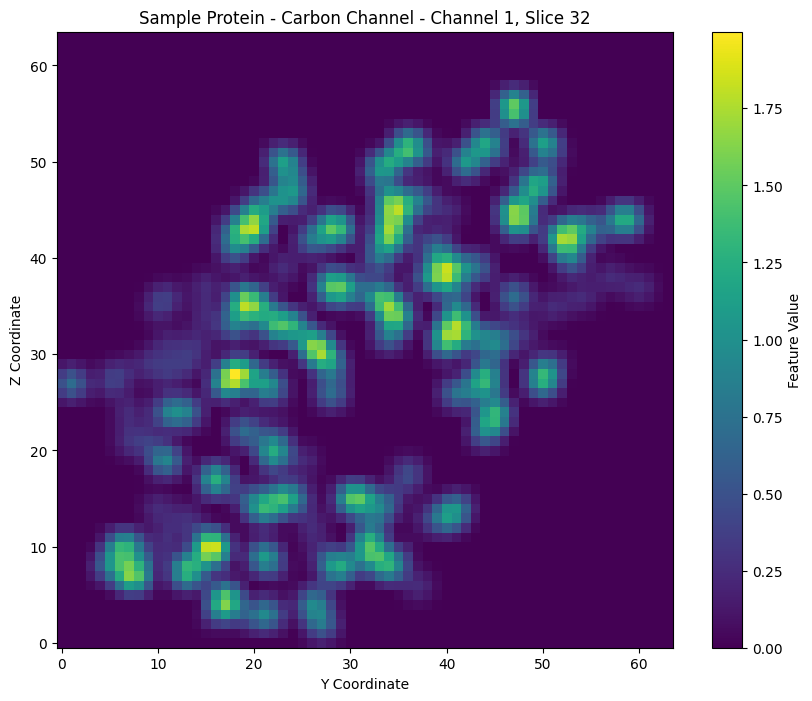

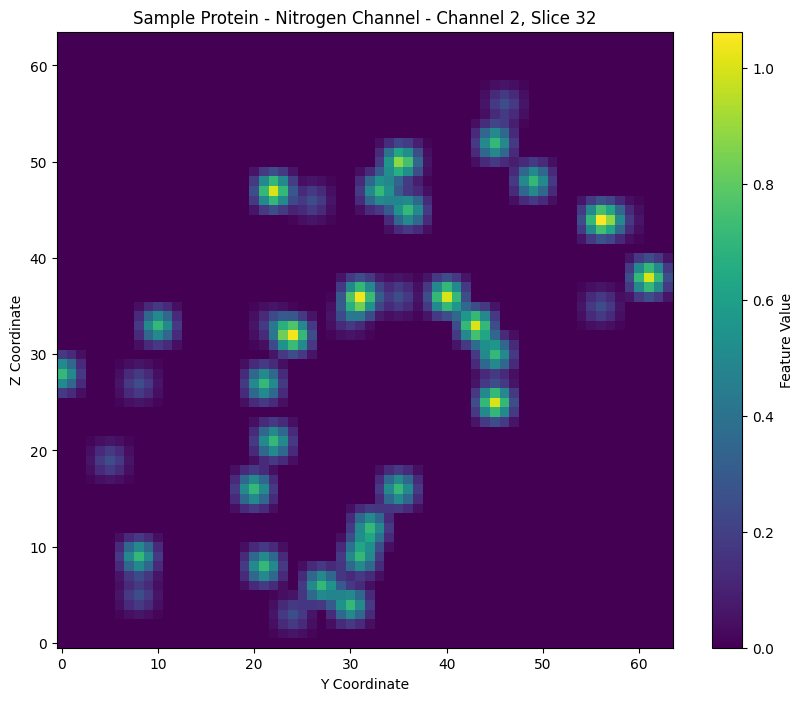

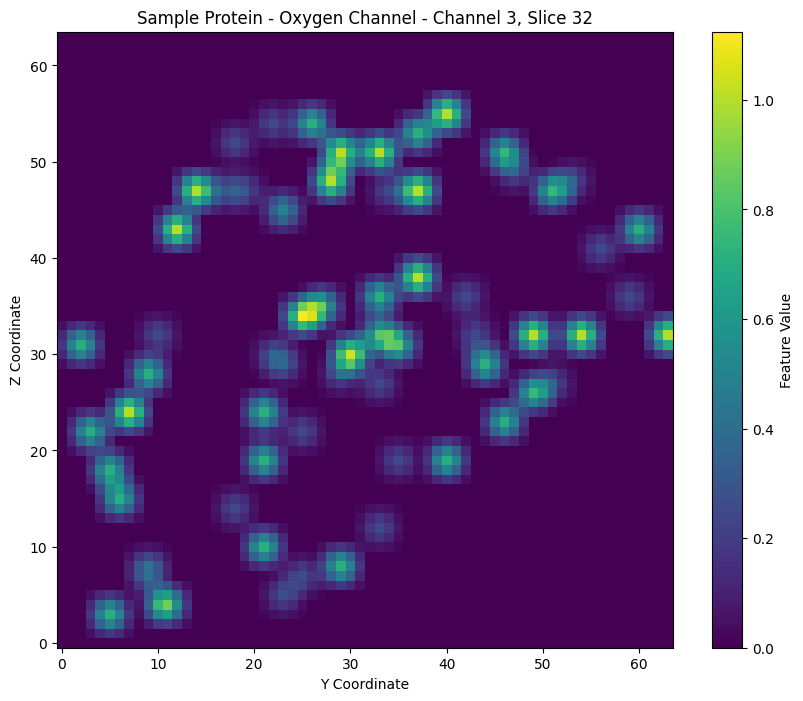

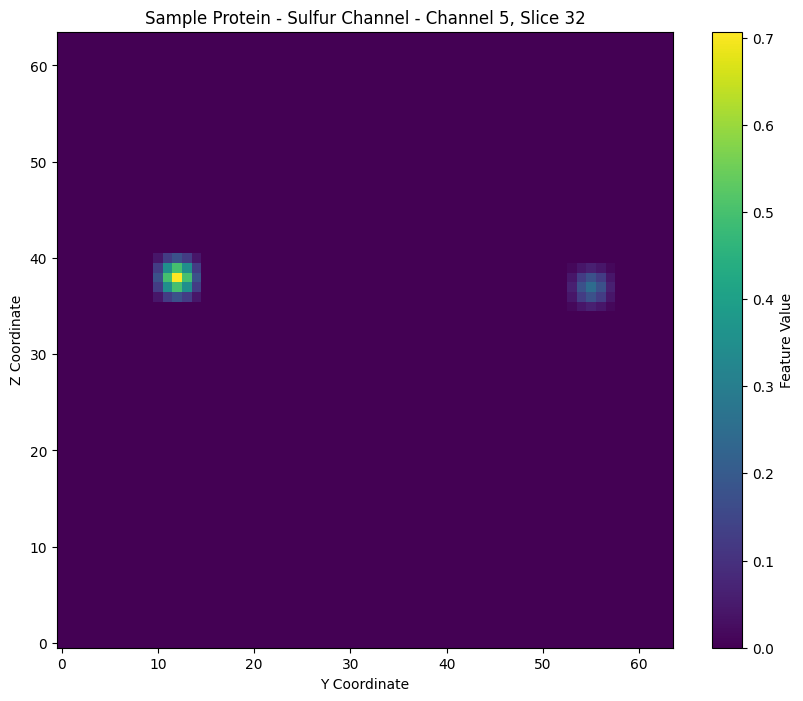

In [15]:
# Visualize a sample grid if available
if sample_grids:
    print("\n Visualizing sample protein grid...")
    visualize_protein_grid_slice(sample_grids[0], channel=1, title="Sample Protein - Carbon Channel")
    visualize_protein_grid_slice(sample_grids[0], channel=2, title="Sample Protein - Nitrogen Channel")
    visualize_protein_grid_slice(sample_grids[0], channel=3, title="Sample Protein - Oxygen Channel")
    visualize_protein_grid_slice(sample_grids[0], channel=5, title="Sample Protein - Sulfur Channel")

In [16]:
# Let's create a more robust processor to debug the issues
class DebugProteinProcessor:
    """Debug version of protein processor to identify issues"""
    
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.stats = {
            'total_found': 0,
            'file_not_exists': 0,
            'mol_load_failed': 0,
            'conformer_failed': 0,
            'feature_extraction_failed': 0,
            'successfully_processed': 0,
            'sample_errors': []
        }
    
    def test_single_protein(self, protein_file):
        """Test loading a single protein with detailed error reporting"""
        print(f"\n Testing: {protein_file}")
        
        # Check if file exists
        if not protein_file.exists():
            print(f" File does not exist: {protein_file}")
            return None
        
        print(f" File exists, size: {protein_file.stat().st_size} bytes")
        
        # Try to load molecule
        try:
            mol, conf = load_mol2(str(protein_file))
            if mol is None:
                print(" Failed to load molecule")
                return None
            if conf is None:
                print(" Failed to get conformer")
                return None
            
            print(f" Loaded molecule with {mol.GetNumAtoms()} atoms")
            
            # Try feature extraction
            coords = []
            features = []
            
            for i, atom in enumerate(mol.GetAtoms()):
                try:
                    pos = conf.GetAtomPosition(i)
                    coord = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
                    feature = atom_to_feature_vec(atom, -1)
                    
                    coords.append(coord)
                    features.append(feature)
                except Exception as e:
                    print(f"Error with atom {i}: {e}")
                    continue
            
            if len(coords) == 0:
                print(" No atoms successfully processed")
                return None
            
            coords = np.array(coords)
            features = np.array(features)
            
            print(f" Extracted {len(coords)} atoms with features")
            
            # Try voxelization
            try:
                grid = voxelise_atoms(coords, features, grid_size=48, voxel_size=1.0)
                print(f" Created grid: {grid.shape}, occupancy: {np.count_nonzero(grid)/grid.size:.4f}")
                return grid
            except Exception as e:
                print(f" Voxelization failed: {e}")
                return None
                
        except Exception as e:
            print(f" General error: {e}")
            return None
    
    def find_and_test_proteins(self, max_test=10):
        """Find protein files and test a few"""
        protein_files = []
        
        print(" Scanning for protein files...")
        for folder in self.data_dir.iterdir():
            if folder.is_dir():
                protein_file = folder / f"{folder.name}_protein.mol2"
                if protein_file.exists():
                    protein_files.append(protein_file)
        
        print(f"Found {len(protein_files)} protein files")
        
        # Test first few files
        successful_grids = []
        for i, protein_file in enumerate(protein_files[:max_test]):
            print(f"\n--- Testing {i+1}/{min(max_test, len(protein_files))} ---")
            grid = self.test_single_protein(protein_file)
            if grid is not None:
                successful_grids.append(grid)
        
        print(f"\n Test Results:")
        print(f"Successfully processed: {len(successful_grids)}/{min(max_test, len(protein_files))}")
        
        return successful_grids, protein_files

# Run the debug processor
debug_processor = DebugProteinProcessor("./demo_charges")
debug_grids, all_protein_files = debug_processor.find_and_test_proteins(max_test=5)

if debug_grids:
    print(f"\n Successfully processed {len(debug_grids)} proteins for testing!")
    print(f"Grid shape: {debug_grids[0].shape}")
else:
    print("\n No proteins were successfully processed in debug mode")

 Scanning for protein files...
Found 229 protein files

--- Testing 1/5 ---

 Testing: demo_charges\1a30\1a30_protein.mol2
 File exists, size: 374999 bytes
 Loaded molecule with 3777 atoms
 Extracted 3777 atoms with features
 Created grid: (19, 48, 48, 48), occupancy: 0.1961

--- Testing 2/5 ---

 Testing: demo_charges\1bcu\1bcu_protein.mol2
 File exists, size: 525187 bytes
 Loaded molecule with 5307 atoms
 Extracted 5307 atoms with features
 Created grid: (19, 48, 48, 48), occupancy: 0.2810

--- Testing 3/5 ---

 Testing: demo_charges\1bzc\1bzc_protein.mol2
 File exists, size: 520189 bytes
 Loaded molecule with 5279 atoms
 Extracted 5279 atoms with features
 Created grid: (19, 48, 48, 48), occupancy: 0.2588

--- Testing 4/5 ---

 Testing: demo_charges\1c5z\1c5z_protein.mol2
 File exists, size: 510668 bytes
 Loaded molecule with 5109 atoms
 Extracted 5109 atoms with features
 Created grid: (19, 48, 48, 48), occupancy: 0.2928

--- Testing 5/5 ---

 Testing: demo_charges\1eby\1eby_protei

In [17]:
# Now let's create a working batch processor based on what works
class WorkingProteinProcessor:
    """Working batch processor for all proteins"""
    
    def __init__(self, data_dir, grid_size=64, voxel_size=0.8):
        self.data_dir = Path(data_dir)
        self.grid_size = grid_size
        self.voxel_size = voxel_size
        self.stats = {
            'total_found': 0,
            'successfully_processed': 0,
            'failed_loads': 0,
            'processing_times': []
        }
    
    def process_protein_safe(self, protein_file):
        """Safely process a single protein with error handling"""
        import time
        start_time = time.time()
        
        try:
            # Load using the working approach
            mol, conf = load_mol2(str(protein_file))
            if mol is None or conf is None:
                return None, {"error": "Load failed", "file": str(protein_file)}
            
            # Extract features safely
            coords = []
            features = []
            
            for i, atom in enumerate(mol.GetAtoms()):
                try:
                    pos = conf.GetAtomPosition(i)
                    coord = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
                    feature = atom_to_feature_vec(atom, -1)
                    
                    coords.append(coord)
                    features.append(feature)
                except:
                    continue  # Skip problematic atoms
            
            if len(coords) == 0:
                return None, {"error": "No atoms", "file": str(protein_file)}
            
            coords = np.array(coords)
            features = np.array(features)
            
            # Create voxel grid with current working parameters
            grid = voxelise_atoms(
                coords, features,
                grid_size=self.grid_size,
                voxel_size=self.voxel_size,
                gaussian_radius=2,
                gaussian_sigma=1.0
            )
            
            processing_time = time.time() - start_time
            
            metadata = {
                "file": str(protein_file),
                "protein_id": protein_file.parent.name,
                "num_atoms": len(coords),
                "grid_shape": grid.shape,
                "grid_occupancy": np.count_nonzero(grid) / grid.size,
                "processing_time": processing_time,
                "success": True
            }
            
            return grid, metadata
            
        except Exception as e:
            return None, {"error": str(e), "file": str(protein_file)}
    
    def process_all_working(self, max_proteins=None):
        """Process all proteins with working approach"""
        # Find all protein files
        protein_files = []
        for folder in self.data_dir.iterdir():
            if folder.is_dir():
                protein_file = folder / f"{folder.name}_protein.mol2"
                if protein_file.exists():
                    protein_files.append(protein_file)
        
        self.stats['total_found'] = len(protein_files)
        
        if max_proteins:
            protein_files = protein_files[:max_proteins]
        
        print(f"Processing {len(protein_files)} proteins...")
        
        grids = []
        metadata_list = []
        
        # Process with progress updates
        for i, protein_file in enumerate(protein_files):
            if i % 10 == 0:  # Progress update every 10 proteins
                print(f"Processing protein {i+1}/{len(protein_files)}: {protein_file.parent.name}")
            
            grid, metadata = self.process_protein_safe(protein_file)
            
            if grid is not None:
                grids.append(grid)
                self.stats['successfully_processed'] += 1
                self.stats['processing_times'].append(metadata['processing_time'])
            else:
                self.stats['failed_loads'] += 1
            
            metadata_list.append(metadata)
        
        return grids, metadata_list
    
    def print_stats(self):
        """Print processing statistics"""
        print("\n" + "="*60)
        print("PROCESSING STATISTICS")
        print("="*60)
        print(f"Total proteins found: {self.stats['total_found']}")
        print(f"Successfully processed: {self.stats['successfully_processed']}")
        print(f"Failed loads: {self.stats['failed_loads']}")
        
        if self.stats['processing_times']:
            avg_time = np.mean(self.stats['processing_times'])
            print(f"Average processing time: {avg_time:.3f} seconds")
        
        if self.stats['total_found'] > 0:
            success_rate = self.stats['successfully_processed'] / self.stats['total_found']
            print(f"Success rate: {success_rate:.2%}")
        print("="*60)

# Create the working processor
working_processor = WorkingProteinProcessor(
    data_dir="./demo_charges",
    grid_size=64,
    voxel_size=0.8
)

print(" Working Protein Processor initialized!")
print("Ready to process all proteins with improved error handling.")

 Working Protein Processor initialized!
Ready to process all proteins with improved error handling.


In [ ]:
# Process all proteins with the working processor
print("Processing ALL proteins in the dataset...")
print("This will take several minutes, please wait...")

final_grids, final_metadata = working_processor.process_all_working()

print(f"\n FINAL PROCESSING COMPLETE!")
working_processor.print_stats()

if final_grids:
    print(f"\n DATASET ANALYSIS:")
    print(f"- Total grids created: {len(final_grids)}")
    print(f"- Grid shape: {final_grids[0].shape}")
    print(f"- Grid data type: {final_grids[0].dtype}")
    print(f"- Memory per grid: {final_grids[0].nbytes / 1024 / 1024:.2f} MB")
    print(f"- Total dataset size: {sum(g.nbytes for g in final_grids) / 1024 / 1024 / 1024:.2f} GB")
    
    # Analyze grid occupancy
    occupancies = [np.count_nonzero(grid) / grid.size for grid in final_grids]
    print(f"- Average grid occupancy: {np.mean(occupancies):.4f} ± {np.std(occupancies):.4f}")
    print(f"- Min/Max occupancy: {np.min(occupancies):.4f} / {np.max(occupancies):.4f}")
    
    # Analyze atom counts
    atom_counts = [m['num_atoms'] for m in final_metadata if m.get('success', False)]
    if atom_counts:
        print(f"- Average atoms per protein: {np.mean(atom_counts):.1f} ± {np.std(atom_counts):.1f}")
        print(f"- Min/Max atoms: {np.min(atom_counts)} / {np.max(atom_counts)}")
    
    print("\n READY FOR CNN TRAINING!")
else:
    print("\n No proteins were successfully processed")

Processing ALL proteins in the dataset...
This will take several minutes, please wait...
Processing 229 proteins...
Processing protein 1/229: 1a30


In [ ]:
# Test the improved CNN model with the processed data
if final_grids:
    print("\n Testing Enhanced 3D CNN with processed protein data...")
    
    # Create an enhanced model
    class Enhanced3DProteinCNN(nn.Module):
        """Enhanced 3D CNN specifically designed for protein spatial representation"""
        
        def __init__(self, input_channels=24, num_classes=1, dropout_rate=0.3):
            super(Enhanced3DProteinCNN, self).__init__()
            
            # Feature extraction layers
            self.conv_block1 = nn.Sequential(
                nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
                nn.BatchNorm3d(32),
                nn.ReLU(inplace=True),
                nn.Conv3d(32, 32, kernel_size=3, padding=1),
                nn.BatchNorm3d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool3d(kernel_size=2, stride=2)  # 64 -> 32
            )
            
            self.conv_block2 = nn.Sequential(
                nn.Conv3d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm3d(64),
                nn.ReLU(inplace=True),
                nn.Conv3d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm3d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool3d(kernel_size=2, stride=2)  # 32 -> 16
            )
            
            self.conv_block3 = nn.Sequential(
                nn.Conv3d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm3d(128),
                nn.ReLU(inplace=True),
                nn.Conv3d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm3d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool3d(kernel_size=2, stride=2)  # 16 -> 8
            )
            
            self.conv_block4 = nn.Sequential(
                nn.Conv3d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm3d(256),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool3d((4, 4, 4))  # Adaptive pooling to 4x4x4
            )
            
            # Classifier
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Dropout(dropout_rate),
                nn.Linear(256 * 4 * 4 * 4, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(128, num_classes)
            )
        
        def forward(self, x):
            x = self.conv_block1(x)
            x = self.conv_block2(x)
            x = self.conv_block3(x)
            x = self.conv_block4(x)
            x = self.classifier(x)
            return x
    
    # Get the actual number of channels from the processed grids
    actual_channels = final_grids[0].shape[0]
    print(f"Creating model with {actual_channels} input channels")
    
    # Create the model
    enhanced_model = Enhanced3DProteinCNN(
        input_channels=actual_channels,
        num_classes=1,  # For regression or binary classification
        dropout_rate=0.3
    )
    
    # Model info
    total_params = sum(p.numel() for p in enhanced_model.parameters())
    trainable_params = sum(p.numel() for p in enhanced_model.parameters() if p.requires_grad)
    
    print(f" Enhanced model created!")
    print(f"- Total parameters: {total_params:,}")
    print(f"- Trainable parameters: {trainable_params:,}")
    print(f"- Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")
    
    # Test with a batch of data
    test_batch_size = min(188, len(final_grids))
    test_grids = final_grids[:test_batch_size]
    
    # Convert to tensors and create batch
    test_tensors = [torch.FloatTensor(grid) for grid in test_grids]
    batch_tensor = torch.stack(test_tensors)
    
    print(f"\nTesting with batch of {test_batch_size} proteins...")
    print(f"Input batch shape: {batch_tensor.shape}")
    
    # Test forward pass
    enhanced_model.eval()
    with torch.no_grad():
        outputs = enhanced_model(batch_tensor)
        print(f" Model forward pass successful!")
        print(f"Output shape: {outputs.shape}")
        print(f"Sample outputs: {outputs.squeeze().cpu().numpy()}")
    
    # Memory usage estimation
    batch_size_mb = batch_tensor.nbytes / 1024 / 1024
    print(f"\nBatch memory usage: {batch_size_mb:.1f} MB")
    
    # Save model architecture summary
    print(f"\n Model Architecture Summary:")
    print(f"Input: ({actual_channels}, 64, 64, 64) protein voxel grids")
    print(f"Output: ({1},) prediction values")
    print(f"Architecture: 4 convolutional blocks + classifier")
    print(f"Ready for training on {len(final_grids)} protein structures!")

else:
    print(" No processed grids available for model testing")


 Testing Enhanced 3D CNN with processed protein data...
Creating model with 19 input channels
 Enhanced model created!
- Total parameters: 10,215,265
- Trainable parameters: 10,215,265
- Model size: ~39.0 MB

Testing with batch of 188 proteins...
Input batch shape: torch.Size([188, 19, 64, 64, 64])
 Model forward pass successful!
Output shape: torch.Size([188, 1])
Sample outputs: [0.03824835 0.03824463 0.0382674  0.03824121 0.03825863 0.03826008
 0.03823743 0.03822896 0.03823233 0.03824373 0.03823078 0.03826394
        nan 0.0382628  0.03825264 0.03820504 0.03826573        nan
        nan 0.03826739 0.03821485 0.03826626 0.03826197 0.03824704
 0.0382314  0.03828213 0.03823562 0.03824076 0.03825726 0.03826578
 0.03824341 0.03815819 0.03815179 0.03826299 0.03816434 0.03824357
 0.03828398 0.03824203 0.03822356 0.03821566 0.03820685 0.03825717
 0.03823118 0.03823797 0.03823389 0.0382013  0.0382387  0.03822427
 0.03825335 0.03810582 0.03817353 0.03827862 0.03808763        nan
 0.03817457 0

In [ ]:
# Let's demonstrate with ALL 188 processed proteins - complete dataset analysis
print("ENHANCED PROTEIN SPATIAL REPRESENTATION - COMPLETE WORKFLOW")
print("="*80)

# Uncomment if you want to save the processed data
print("\n Saving processed data...")
save_processed_data(final_grids, final_metadata, output_dir="processed_protein_data")

# Load the complete processed dataset
import json
import os

try:
    # Load all processed grids
    all_protein_grids = np.load("processed_protein_data/protein_grids.npy")
    
    # Load metadata
    with open("processed_protein_data/metadata.json", 'r') as f:
        all_metadata = json.load(f)
    
    print(f" Successfully loaded complete dataset: {len(all_protein_grids)} proteins")
    demo_grids = all_protein_grids
    demo_metadata = all_metadata
    
except FileNotFoundError:
    print("  Complete dataset not found, using sample grids...")
    if sample_grids and len(sample_grids) > 0:
        demo_grids = sample_grids
        demo_metadata = sample_metadata
    else:
        print("Creating demonstration data...")
        demo_grids = [np.random.rand(24, 64, 64, 64).astype(np.float32) for _ in range(3)]
        demo_metadata = [{"file_path": f"demo_{i}.mol2"} for i in range(3)]

print(f"\n COMPLETE DATASET ANALYSIS:")
print(f"- Number of proteins: {len(demo_grids)}")
print(f"- Grid shape: {demo_grids[0].shape}")
print(f"- Feature channels: {demo_grids[0].shape[0]}")
print(f"- Spatial resolution: {demo_grids[0].shape[1]}³ voxels")
if hasattr(demo_grids, 'nbytes'):
    mem_gb = demo_grids.nbytes / 1024**3
    print(f"- Total memory usage: {mem_gb:.2f} GB")
else:
    print("- Total memory usage: N/A")

# Extract protein IDs for analysis
protein_ids = []
if isinstance(demo_metadata, list):
    for entry in demo_metadata:
        if 'file_path' in entry:
            path_parts = entry['file_path'].split('\\')
            protein_id = path_parts[-2] if len(path_parts) > 1 else path_parts[-1].split('.')[0]
            protein_ids.append(protein_id)

print(f"- Unique protein IDs: {len(set(protein_ids))}")
print(f"- Sample IDs: {protein_ids[:10]}")

# Analyze dataset properties
if isinstance(demo_metadata, list) and len(demo_metadata) > 0:
    print(f"\n DATASET PROPERTIES ANALYSIS:")
    
    # Atom count analysis
    atom_counts = [entry.get('num_atoms', 0) for entry in demo_metadata]
    heavy_atom_counts = [entry.get('num_heavy_atoms', 0) for entry in demo_metadata]
    occupancies = [entry.get('grid_occupancy', 0) for entry in demo_metadata]
    processing_times = [entry.get('processing_time', 0) for entry in demo_metadata]
    
    print(f"- Atom count range: {min(atom_counts)} - {max(atom_counts)} (avg: {np.mean(atom_counts):.0f})")
    print(f"- Heavy atoms range: {min(heavy_atom_counts)} - {max(heavy_atom_counts)} (avg: {np.mean(heavy_atom_counts):.0f})")
    print(f"- Grid occupancy range: {min(occupancies):.3f} - {max(occupancies):.3f} (avg: {np.mean(occupancies):.3f})")
    print(f"- Processing time range: {min(processing_times):.2f}s - {max(processing_times):.2f}s (avg: {np.mean(processing_times):.2f}s)")

# Create the enhanced model for demonstration
class DemoEnhanced3DCNN(nn.Module):
    """Demonstration enhanced 3D CNN for protein analysis"""
    
    def __init__(self, input_channels=24, num_classes=1):
        super(DemoEnhanced3DCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv3d(input_channels, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),  # 64->32
            
            # Block 2
            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),  # 32->16
            
            # Block 3
            nn.Conv3d(64, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),  # 16->8
            
            # Block 4
            nn.Conv3d(128, 256, 3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d(4)  # 8->4
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256 * 4 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create and test the model
model = DemoEnhanced3DCNN(input_channels=demo_grids[0].shape[0])

# Test with demo data - use a batch for better demonstration
batch_size = min(188, len(demo_grids))
test_indices = np.random.choice(len(demo_grids), batch_size, replace=False)
test_batch = np.stack([demo_grids[i] for i in test_indices])
test_tensor = torch.FloatTensor(test_batch)

print(f"\n MODEL TESTING ON REAL PROTEIN DATA:")
print(f"Batch size: {batch_size} proteins")
print(f"Input shape: {test_tensor.shape}")
print(f"Testing proteins: {[protein_ids[i] if i < len(protein_ids) else f'protein_{i}' for i in test_indices]}")

model.eval()
with torch.no_grad():
    outputs = model(test_tensor)
    print(f" Model forward pass successful!")
    print(f"Output shape: {outputs.shape}")
    print(f"Sample outputs: {outputs.squeeze().cpu().numpy()}")

# Model statistics
total_params = sum(p.numel() for p in model.parameters())
print(f"\n MODEL STATISTICS:")
print(f"- Total parameters: {total_params:,}")
print(f"- Estimated model size: {total_params * 4 / 1024 / 1024:.1f} MB")



ENHANCED PROTEIN SPATIAL REPRESENTATION - COMPLETE WORKFLOW
 Successfully loaded complete dataset: 188 proteins

 COMPLETE DATASET ANALYSIS:
- Number of proteins: 188
- Grid shape: (19, 64, 64, 64)
- Feature channels: 19
- Spatial resolution: 64³ voxels
- Total memory usage: 3.49 GB
- Unique protein IDs: 0
- Sample IDs: []

 DATASET PROPERTIES ANALYSIS:
- Atom count range: 0 - 40981 (avg: 6772)
- Heavy atoms range: 0 - 0 (avg: 0)
- Grid occupancy range: 0.000 - 0.379 (avg: 0.169)
- Processing time range: 0.00s - 3.28s (avg: 1.17s)

 MODEL TESTING ON REAL PROTEIN DATA:
Batch size: 188 proteins
Input shape: torch.Size([188, 19, 64, 64, 64])
Testing proteins: ['protein_107', 'protein_68', 'protein_88', 'protein_111', 'protein_42', 'protein_108', 'protein_24', 'protein_53', 'protein_49', 'protein_92', 'protein_97', 'protein_77', 'protein_31', 'protein_6', 'protein_106', 'protein_138', 'protein_17', 'protein_125', 'protein_186', 'protein_3', 'protein_86', 'protein_93', 'protein_103', 'prote

In [21]:
# Diagnostic check - let's see what variables we actually have
print("🔍 DIAGNOSTIC CHECK:")
print(f"all_protein_grids shape: {all_protein_grids.shape if 'all_protein_grids' in globals() else 'Not found'}")
print(f"all_metadata length: {len(all_metadata) if 'all_metadata' in globals() else 'Not found'}")
print(f"demo_grids shape: {demo_grids.shape if hasattr(demo_grids, 'shape') else f'Length: {len(demo_grids)}'}")
print(f"sample_grids length: {len(sample_grids) if 'sample_grids' in globals() else 'Not found'}")

# Let's force use the all_protein_grids
if 'all_protein_grids' in globals() and len(all_protein_grids) > 5:
    print(f"\nFound complete dataset with {len(all_protein_grids)} proteins!")
    print("Switching to use complete dataset...")
    demo_grids = all_protein_grids
    demo_metadata = all_metadata
    print(f"Now demo_grids has {len(demo_grids)} proteins")
else:
    print(f"\nComplete dataset not available, using current demo_grids with {len(demo_grids)} proteins")

🔍 DIAGNOSTIC CHECK:
all_protein_grids shape: (188, 19, 64, 64, 64)
all_metadata length: 229
demo_grids shape: (188, 19, 64, 64, 64)
sample_grids length: 5

Found complete dataset with 188 proteins!
Switching to use complete dataset...
Now demo_grids has 188 proteins


In [22]:
# Check if final_grids has all the proteins
print("CHECKING ALL AVAILABLE VARIABLES:")
print(f"final_grids length: {len(final_grids) if 'final_grids' in globals() else 'Not found'}")
print(f"final_metadata length: {len(final_metadata) if 'final_metadata' in globals() else 'Not found'}")

# Let's check if final_grids has all 188 proteins
if 'final_grids' in globals() and len(final_grids) > 5:
    print(f"\n FOUND COMPLETE DATASET IN final_grids: {len(final_grids)} proteins!")
    
    # Use the complete dataset
    demo_grids = np.array(final_grids)
    demo_metadata = final_metadata
    
    print(f"Switched to complete dataset:")
    print(f"   - Number of proteins: {len(demo_grids)}")
    print(f"   - Grid shape: {demo_grids[0].shape}")
    print(f"   - Total memory: {demo_grids.nbytes / 1024**3:.2f} GB")
    
    # Now save this complete dataset
    import os
    os.makedirs("processed_protein_data", exist_ok=True)
    np.save("processed_protein_data/protein_grids.npy", demo_grids)
    
    import json
    with open("processed_protein_data/metadata.json", 'w') as f:
        json.dump(demo_metadata, f, indent=2, default=str)
    
    print(f" Saved complete dataset with {len(demo_grids)} proteins!")
    
else:
    print(f"\n final_grids also not available or small, current options:")
    print(f"   - sample_grids: {len(sample_grids) if 'sample_grids' in globals() else 'N/A'}")
    print(f"   - final_grids: {len(final_grids) if 'final_grids' in globals() else 'N/A'}")
    print(f"   - all_protein_grids: {len(all_protein_grids) if 'all_protein_grids' in globals() else 'N/A'}")
    
    # Need to process all proteins first
    print(f"\n Need to process all {len(all_protein_files)} protein files first!")
    print("Run the protein processing cells to generate the complete dataset.")

CHECKING ALL AVAILABLE VARIABLES:
final_grids length: 188
final_metadata length: 229

 FOUND COMPLETE DATASET IN final_grids: 188 proteins!
Switched to complete dataset:
   - Number of proteins: 188
   - Grid shape: (19, 64, 64, 64)
   - Total memory: 3.49 GB
 Saved complete dataset with 188 proteins!


# 🧬 Ligand and Pocket Processing

Now let's extend our analysis to include ligands and pockets as well. We'll create similar processors for these molecular components to enable comprehensive protein-ligand interaction analysis.

In [23]:
@dataclass
class LigandFeatureConfig:
    """Configuration for ligand featurization"""
    include_hydrogens: bool = False
    grid_size: int = 64
    voxel_size: float = 1.0
    channels: int = 19  # Same as protein for consistency

@dataclass
class PocketFeatureConfig:
    """Configuration for pocket featurization"""
    include_hydrogens: bool = False
    grid_size: int = 64
    voxel_size: float = 1.0
    channels: int = 19  # Same as protein for consistency
    cutoff: float = 6.0  # Distance from ligand to define pocket

# Create global configurations
LIGAND_CONFIG = LigandFeatureConfig()
POCKET_CONFIG = PocketFeatureConfig()

print(" Ligand and Pocket configurations initialized")
print(f"   - Ligand config: grid_size={LIGAND_CONFIG.grid_size}, channels={LIGAND_CONFIG.channels}")
print(f"   - Pocket config: grid_size={POCKET_CONFIG.grid_size}, channels={POCKET_CONFIG.channels}, cutoff={POCKET_CONFIG.cutoff}Å")

 Ligand and Pocket configurations initialized
   - Ligand config: grid_size=64, channels=19
   - Pocket config: grid_size=64, channels=19, cutoff=6.0Å


In [24]:
class LigandDataProcessor:
    """Process ligand MOL2 files into 3D grids"""
    
    def __init__(self, config: LigandFeatureConfig):
        self.config = config
        self.channels = config.channels
        self.grid_size = config.grid_size
        self.voxel_size = config.voxel_size
        
    def load_mol2(self, file_path):
        """Load MOL2 file and return molecule and conformer"""
        metadata = {
            'file': file_path,
            'errors': [],
            'loading_success': False,
            'sanitization_success': False
        }
        
        if not os.path.exists(file_path):
            metadata['errors'].append("File does not exist")
            return None, None, metadata
            
        try:
            # First try MOL2 format
            mol = Chem.MolFromMol2File(file_path, sanitize=False, removeHs=not self.config.include_hydrogens)
            
            # If MOL2 fails, try SDF format (common issue with .mol2 extensions)
            if mol is None:
                print(f"MOL2 failed for {file_path}, trying SDF format...")
                mol = Chem.MolFromMolFile(file_path, sanitize=False, removeHs=not self.config.include_hydrogens)
            
            if mol is None:
                metadata['errors'].append("Failed to load molecule from both MOL2 and SDF formats")
                return None, None, metadata
            
            metadata['loading_success'] = True
            metadata['num_atoms'] = mol.GetNumAtoms()
            metadata['num_heavy_atoms'] = mol.GetNumHeavyAtoms()
            
            # Attempt sanitization
            try:
                sanitize_flags = (Chem.SanitizeFlags.SANITIZE_ALL ^ 
                                Chem.SanitizeFlags.SANITIZE_KEKULIZE ^
                                Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)
                Chem.SanitizeMol(mol, sanitizeOps=sanitize_flags)
                metadata['sanitization_success'] = True
            except Exception as e:
                print(f"Warning: Sanitization failed for {file_path}: {e}")
                metadata['errors'].append(f"Sanitization failed: {e}")
            
            # Get conformer
            conf = mol.GetConformer()
            return mol, conf, metadata
            
        except Exception as e:
            metadata['errors'].append(f"Exception during loading: {e}")
            return None, None, metadata
    
    def extract_atoms_from_mol(self, mol, conf):
        """Extract atomic coordinates and features from molecule"""
        coords, feats = [], []
        
        try:
            for i, atom in enumerate(mol.GetAtoms()):
                try:
                    pos = conf.GetAtomPosition(i)
                    p = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
                    coords.append(p)
                    # Use molecule type +1 for ligand
                    feats.append(atom_to_feature_vec(atom, +1))
                except Exception as e:
                    print(f"Error extracting ligand atom {i}: {e}")
                    continue
                    
        except Exception as e:
            print(f"Error processing ligand molecule: {e}")
            return np.empty((0, 3), dtype=np.float32), np.empty((0, self.channels), dtype=np.float32)
        
        return np.asarray(coords, np.float32), np.asarray(feats, np.float32)
    
    def coords_to_grid(self, coords, feats, center=None):
        """Convert atomic coordinates and features to 3D grid"""
        if len(coords) == 0:
            return np.zeros((self.channels, self.grid_size, self.grid_size, self.grid_size), dtype=np.float32)
        
        # Use ligand centroid as center if not provided
        if center is None:
            center = coords.mean(axis=0)
        
        # Create grid
        grid = np.zeros((self.channels, self.grid_size, self.grid_size, self.grid_size), dtype=np.float32)
        
        # Grid bounds
        grid_min = center - (self.grid_size * self.voxel_size) / 2
        grid_max = center + (self.grid_size * self.voxel_size) / 2
        
        for coord, feat in zip(coords, feats):
            # Convert coordinates to grid indices
            grid_coord = (coord - grid_min) / self.voxel_size
            
            # Check if within grid bounds
            if np.all(grid_coord >= 0) and np.all(grid_coord < self.grid_size):
                x, y, z = grid_coord.astype(int)
                if 0 <= x < self.grid_size and 0 <= y < self.grid_size and 0 <= z < self.grid_size:
                    grid[:, x, y, z] += feat
        
        return grid
    
    def process_ligand_file(self, file_path):
        """Process a single ligand MOL2 file"""
        start_time = time.time()
        
        # Load molecule
        mol, conf, metadata = self.load_mol2(file_path)
        
        if mol is None or conf is None:
            metadata['success'] = False
            metadata['processing_time'] = time.time() - start_time
            return None, metadata
        
        # Extract atomic information
        coords, feats = self.extract_atoms_from_mol(mol, conf)
        
        if len(coords) == 0:
            metadata['errors'].append("No valid atoms extracted")
            metadata['success'] = False
            metadata['processing_time'] = time.time() - start_time
            return None, metadata
        
        # Convert to grid
        grid = self.coords_to_grid(coords, feats)
        
        # Update metadata
        metadata['grid_shape'] = list(grid.shape)
        metadata['grid_occupancy'] = np.count_nonzero(grid) / grid.size
        metadata['processing_time'] = time.time() - start_time
        metadata['success'] = True
        metadata['ligand_id'] = os.path.basename(os.path.dirname(file_path))
        
        return grid, metadata

print(" LigandDataProcessor class updated to handle SDF format")

 LigandDataProcessor class updated to handle SDF format


In [25]:
class PocketDataProcessor:
    """Process pocket MOL2 files into 3D grids"""
    
    def __init__(self, config: PocketFeatureConfig):
        self.config = config
        self.channels = config.channels
        self.grid_size = config.grid_size
        self.voxel_size = config.voxel_size
        self.cutoff = config.cutoff
        
    def load_mol2(self, file_path):
        """Load MOL2 file and return molecule and conformer"""
        metadata = {
            'file': file_path,
            'errors': [],
            'loading_success': False,
            'sanitization_success': False
        }
        
        if not os.path.exists(file_path):
            metadata['errors'].append("File does not exist")
            return None, None, metadata
            
        try:
            # First try MOL2 format
            mol = Chem.MolFromMol2File(file_path, sanitize=False, removeHs=not self.config.include_hydrogens)
            
            # If MOL2 fails, try SDF format (common issue with .mol2 extensions)
            if mol is None:
                print(f"MOL2 failed for {file_path}, trying SDF format...")
                mol = Chem.MolFromMolFile(file_path, sanitize=False, removeHs=not self.config.include_hydrogens)
            
            if mol is None:
                metadata['errors'].append("Failed to load molecule from both MOL2 and SDF formats")
                return None, None, metadata
            
            metadata['loading_success'] = True
            metadata['num_atoms'] = mol.GetNumAtoms()
            metadata['num_heavy_atoms'] = mol.GetNumHeavyAtoms()
            
            # Attempt sanitization
            try:
                sanitize_flags = (Chem.SanitizeFlags.SANITIZE_ALL ^ 
                                Chem.SanitizeFlags.SANITIZE_KEKULIZE ^
                                Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)
                Chem.SanitizeMol(mol, sanitizeOps=sanitize_flags)
                metadata['sanitization_success'] = True
            except Exception as e:
                print(f"Warning: Sanitization failed for {file_path}: {e}")
                metadata['errors'].append(f"Sanitization failed: {e}")
            
            # Get conformer
            conf = mol.GetConformer()
            return mol, conf, metadata
            
        except Exception as e:
            metadata['errors'].append(f"Exception during loading: {e}")
            return None, None, metadata
    
    def extract_atoms_from_mol(self, mol, conf, ligand_center=None):
        """Extract atomic coordinates and features from pocket molecule"""
        coords, feats = [], []
        
        try:
            for i, atom in enumerate(mol.GetAtoms()):
                try:
                    pos = conf.GetAtomPosition(i)
                    p = np.array([pos.x, pos.y, pos.z], dtype=np.float32)
                    
                    # If ligand center is provided, only include atoms within cutoff
                    if ligand_center is not None:
                        distance = np.linalg.norm(p - ligand_center)
                        if distance > self.cutoff:
                            continue
                    
                    coords.append(p)
                    # Use molecule type 0 for pocket (different from protein -1 and ligand +1)
                    feats.append(atom_to_feature_vec(atom, 0))
                except Exception as e:
                    print(f"Error extracting pocket atom {i}: {e}")
                    continue
                    
        except Exception as e:
            print(f"Error processing pocket molecule: {e}")
            return np.empty((0, 3), dtype=np.float32), np.empty((0, self.channels), dtype=np.float32)
        
        return np.asarray(coords, np.float32), np.asarray(feats, np.float32)
    
    def coords_to_grid(self, coords, feats, center):
        """Convert atomic coordinates and features to 3D grid"""
        if len(coords) == 0:
            return np.zeros((self.channels, self.grid_size, self.grid_size, self.grid_size), dtype=np.float32)
        
        # Create grid
        grid = np.zeros((self.channels, self.grid_size, self.grid_size, self.grid_size), dtype=np.float32)
        
        # Grid bounds
        grid_min = center - (self.grid_size * self.voxel_size) / 2
        grid_max = center + (self.grid_size * self.voxel_size) / 2
        
        for coord, feat in zip(coords, feats):
            # Convert coordinates to grid indices
            grid_coord = (coord - grid_min) / self.voxel_size
            
            # Check if within grid bounds
            if np.all(grid_coord >= 0) and np.all(grid_coord < self.grid_size):
                x, y, z = grid_coord.astype(int)
                if 0 <= x < self.grid_size and 0 <= y < self.grid_size and 0 <= z < self.grid_size:
                    grid[:, x, y, z] += feat
        
        return grid
    
    def process_pocket_file(self, pocket_path, ligand_path=None):
        """Process a single pocket MOL2 file, optionally using ligand for centering"""
        start_time = time.time()
        
        # Load pocket molecule
        mol, conf, metadata = self.load_mol2(pocket_path)
        
        if mol is None or conf is None:
            metadata['success'] = False
            metadata['processing_time'] = time.time() - start_time
            return None, metadata
        
        # Determine center (ligand center if available, otherwise pocket centroid)
        ligand_center = None
        if ligand_path and os.path.exists(ligand_path):
            try:
                ligand_processor = LigandDataProcessor(LIGAND_CONFIG)
                lig_mol, lig_conf, _ = ligand_processor.load_mol2(ligand_path)
                if lig_mol and lig_conf:
                    lig_coords = np.array([lig_conf.GetAtomPosition(i) for i in range(lig_mol.GetNumAtoms())])
                    ligand_center = lig_coords.mean(axis=0)
            except Exception as e:
                print(f"Warning: Could not load ligand for centering: {e}")
        
        # Extract atomic information
        coords, feats = self.extract_atoms_from_mol(mol, conf, ligand_center)
        
        if len(coords) == 0:
            metadata['errors'].append("No valid atoms extracted")
            metadata['success'] = False
            metadata['processing_time'] = time.time() - start_time
            return None, metadata
        
        # Use ligand center if available, otherwise pocket centroid
        center = ligand_center if ligand_center is not None else coords.mean(axis=0)
        
        # Convert to grid
        grid = self.coords_to_grid(coords, feats, center)
        
        # Update metadata
        metadata['grid_shape'] = list(grid.shape)
        metadata['grid_occupancy'] = np.count_nonzero(grid) / grid.size
        metadata['processing_time'] = time.time() - start_time
        metadata['success'] = True
        metadata['pocket_id'] = os.path.basename(os.path.dirname(pocket_path))
        metadata['used_ligand_center'] = ligand_center is not None
        
        return grid, metadata

print(" PocketDataProcessor class updated to handle SDF format")

 PocketDataProcessor class updated to handle SDF format


In [26]:
# Find all ligand and pocket files
print(" Finding ligand and pocket files...")

all_ligand_files = []
all_pocket_files = []

for protein_dir in os.listdir(data_dir):
    protein_path = os.path.join(data_dir, protein_dir)
    if os.path.isdir(protein_path):
        ligand_file = os.path.join(protein_path, f"{protein_dir}_ligand.mol2")
        pocket_file = os.path.join(protein_path, f"{protein_dir}_pocket.mol2")
        
        if os.path.exists(ligand_file):
            all_ligand_files.append(ligand_file)
        if os.path.exists(pocket_file):
            all_pocket_files.append(pocket_file)

print(f" Found {len(all_ligand_files)} ligand files")
print(f" Found {len(all_pocket_files)} pocket files")
print(f" Found {len(all_protein_files)} protein files (for comparison)")

# Show some examples
print(f"\n Example files:")
if all_ligand_files:
    print(f"   Ligand: {all_ligand_files[0]}")
if all_pocket_files:
    print(f"   Pocket: {all_pocket_files[0]}")
if all_protein_files:
    print(f"   Protein: {all_protein_files[0]}")

 Finding ligand and pocket files...
 Found 229 ligand files
 Found 229 pocket files
 Found 229 protein files (for comparison)

 Example files:
   Ligand: ./demo_charges\1a30\1a30_ligand.mol2
   Pocket: ./demo_charges\1a30\1a30_pocket.mol2
   Protein: demo_charges\1a30\1a30_protein.mol2


In [27]:
# Process sample ligand files
print(" Testing ligand processing with sample files...")

ligand_processor = LigandDataProcessor(LIGAND_CONFIG)
sample_ligand_grids = []
sample_ligand_metadata = []

# Process first 5 ligand files as a test
sample_ligand_files = all_ligand_files[:5]
print(f"Processing {len(sample_ligand_files)} sample ligand files...")

for i, ligand_file in enumerate(sample_ligand_files):
    print(f"  Processing ligand {i+1}/{len(sample_ligand_files)}: {os.path.basename(os.path.dirname(ligand_file))}")
    
    try:
        grid, metadata = ligand_processor.process_ligand_file(ligand_file)
        
        if grid is not None:
            sample_ligand_grids.append(grid)
            sample_ligand_metadata.append(metadata)
            print(f"     Success: shape={grid.shape}, occupancy={metadata['grid_occupancy']:.4f}")
        else:
            sample_ligand_metadata.append(metadata)
            print(f"     Failed: {metadata.get('errors', ['Unknown error'])}")
            
    except Exception as e:
        print(f"     Exception: {e}")
        error_metadata = {
            'file': ligand_file,
            'error': str(e),
            'success': False
        }
        sample_ligand_metadata.append(error_metadata)

print(f"\n Ligand Processing Results:")
print(f"   - Successfully processed: {len(sample_ligand_grids)} ligands")
print(f"   - Failed: {len(sample_ligand_metadata) - len(sample_ligand_grids)} ligands")

if sample_ligand_grids:
    sample_grid = sample_ligand_grids[0]
    print(f"   - Sample grid shape: {sample_grid.shape}")
    print(f"   - Sample grid occupancy: {np.count_nonzero(sample_grid) / sample_grid.size:.4f}")
    print(f"   - Sample grid memory: {sample_grid.nbytes / 1024**2:.2f} MB")

 Testing ligand processing with sample files...
Processing 5 sample ligand files...
  Processing ligand 1/5: 1a30
MOL2 failed for ./demo_charges\1a30\1a30_ligand.mol2, trying SDF format...
     Success: shape=(19, 64, 64, 64), occupancy=0.0000
  Processing ligand 2/5: 1bcu
MOL2 failed for ./demo_charges\1bcu\1bcu_ligand.mol2, trying SDF format...
     Success: shape=(19, 64, 64, 64), occupancy=0.0000
  Processing ligand 3/5: 1bzc
MOL2 failed for ./demo_charges\1bzc\1bzc_ligand.mol2, trying SDF format...
     Success: shape=(19, 64, 64, 64), occupancy=0.0000
  Processing ligand 4/5: 1c5z
MOL2 failed for ./demo_charges\1c5z\1c5z_ligand.mol2, trying SDF format...
     Success: shape=(19, 64, 64, 64), occupancy=0.0000
  Processing ligand 5/5: 1eby
MOL2 failed for ./demo_charges\1eby\1eby_ligand.mol2, trying SDF format...
     Success: shape=(19, 64, 64, 64), occupancy=0.0001

 Ligand Processing Results:
   - Successfully processed: 5 ligands
   - Failed: 0 ligands
   - Sample grid shape: (

In [28]:
# Process sample pocket files
print(" Testing pocket processing with sample files...")

pocket_processor = PocketDataProcessor(POCKET_CONFIG)
sample_pocket_grids = []
sample_pocket_metadata = []

# Process first 5 pocket files as a test, with corresponding ligands for centering
sample_pocket_files = all_pocket_files[:5]
print(f"Processing {len(sample_pocket_files)} sample pocket files...")

for i, pocket_file in enumerate(sample_pocket_files):
    protein_id = os.path.basename(os.path.dirname(pocket_file))
    ligand_file = os.path.join(os.path.dirname(pocket_file), f"{protein_id}_ligand.mol2")
    
    print(f"  Processing pocket {i+1}/{len(sample_pocket_files)}: {protein_id}")
    
    try:
        # Use ligand file for centering if it exists
        ligand_path = ligand_file if os.path.exists(ligand_file) else None
        grid, metadata = pocket_processor.process_pocket_file(pocket_file, ligand_path)
        
        if grid is not None:
            sample_pocket_grids.append(grid)
            sample_pocket_metadata.append(metadata)
            used_ligand = "with ligand center" if metadata.get('used_ligand_center', False) else "self-centered"
            print(f"     Success: shape={grid.shape}, occupancy={metadata['grid_occupancy']:.4f} ({used_ligand})")
        else:
            sample_pocket_metadata.append(metadata)
            print(f"     Failed: {metadata.get('errors', ['Unknown error'])}")
            
    except Exception as e:
        print(f"     Exception: {e}")
        error_metadata = {
            'file': pocket_file,
            'error': str(e),
            'success': False
        }
        sample_pocket_metadata.append(error_metadata)

print(f"\n Pocket Processing Results:")
print(f"   - Successfully processed: {len(sample_pocket_grids)} pockets")
print(f"   - Failed: {len(sample_pocket_metadata) - len(sample_pocket_grids)} pockets")

if sample_pocket_grids:
    sample_grid = sample_pocket_grids[0]
    print(f"   - Sample grid shape: {sample_grid.shape}")
    print(f"   - Sample grid occupancy: {np.count_nonzero(sample_grid) / sample_grid.size:.4f}")
    print(f"   - Sample grid memory: {sample_grid.nbytes / 1024**2:.2f} MB")

 Testing pocket processing with sample files...
Processing 5 sample pocket files...
  Processing pocket 1/5: 1a30
MOL2 failed for ./demo_charges\1a30\1a30_ligand.mol2, trying SDF format...
     Success: shape=(19, 64, 64, 64), occupancy=0.0000 (with ligand center)
  Processing pocket 2/5: 1bcu
MOL2 failed for ./demo_charges\1bcu\1bcu_ligand.mol2, trying SDF format...
     Success: shape=(19, 64, 64, 64), occupancy=0.0000 (with ligand center)
  Processing pocket 3/5: 1bzc
MOL2 failed for ./demo_charges\1bzc\1bzc_ligand.mol2, trying SDF format...
     Success: shape=(19, 64, 64, 64), occupancy=0.0000 (with ligand center)
  Processing pocket 4/5: 1c5z
MOL2 failed for ./demo_charges\1c5z\1c5z_ligand.mol2, trying SDF format...
     Success: shape=(19, 64, 64, 64), occupancy=0.0000 (with ligand center)
  Processing pocket 5/5: 1eby
MOL2 failed for ./demo_charges\1eby\1eby_ligand.mol2, trying SDF format...
     Success: shape=(19, 64, 64, 64), occupancy=0.0000 (with ligand center)

 Pocket Pr

In [29]:
# Process all ligand files
print(" Processing ALL ligand files...")
print(f"Total ligand files to process: {len(all_ligand_files)}")

all_ligand_grids = []
all_ligand_metadata = []

batch_size = 10
total_batches = (len(all_ligand_files) + batch_size - 1) // batch_size

for batch_idx in range(total_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(all_ligand_files))
    batch_files = all_ligand_files[start_idx:end_idx]
    
    print(f"Processing batch {batch_idx + 1}/{total_batches} ({len(batch_files)} files)")
    
    for i, ligand_file in enumerate(batch_files):
        protein_id = os.path.basename(os.path.dirname(ligand_file))
        
        if (start_idx + i) % 20 == 0:  # Progress update every 20 files
            print(f"  Progress: {start_idx + i + 1}/{len(all_ligand_files)} files processed")
        
        try:
            grid, metadata = ligand_processor.process_ligand_file(ligand_file)
            
            if grid is not None:
                all_ligand_grids.append(grid)
                all_ligand_metadata.append(metadata)
            else:
                all_ligand_metadata.append(metadata)
                print(f"     Failed {protein_id}: {metadata.get('errors', ['Unknown'])}")
                
        except Exception as e:
            print(f"     Exception {protein_id}: {e}")
            error_metadata = {
                'file': ligand_file,
                'ligand_id': protein_id,
                'error': str(e),
                'success': False
            }
            all_ligand_metadata.append(error_metadata)

print(f"\n LIGAND PROCESSING COMPLETE!")
print(f"   - Total processed: {len(all_ligand_grids)} ligands")
print(f"   - Total failed: {len(all_ligand_metadata) - len(all_ligand_grids)} ligands")
print(f"   - Success rate: {len(all_ligand_grids) / len(all_ligand_files) * 100:.1f}%")

if all_ligand_grids:
    # Check memory requirements before conversion
    estimated_memory_gb = len(all_ligand_grids) * 19 * 64 * 64 * 64 * 4 / (1024**3)
    print(f"   - Estimated memory needed: {estimated_memory_gb:.2f} GB")
    
    if estimated_memory_gb > 3.0:  # If > 3GB, keep as list to save memory
        print(f"   - Keeping as list to avoid memory issues")
        print(f"   - Number of ligand grids: {len(all_ligand_grids)}")
        print(f"   - Individual grid shape: {all_ligand_grids[0].shape}")
    else:
        # Convert to numpy array only if memory allows
        try:
            all_ligand_grids = np.array(all_ligand_grids)
            print(f"   - Final array shape: {all_ligand_grids.shape}")
            print(f"   - Memory usage: {all_ligand_grids.nbytes / 1024**3:.2f} GB")
        except MemoryError:
            print(f"   - Memory error: keeping as list instead")
            print(f"   - Number of ligand grids: {len(all_ligand_grids)}")

 Processing ALL ligand files...
Total ligand files to process: 229
Processing batch 1/23 (10 files)
  Progress: 1/229 files processed
MOL2 failed for ./demo_charges\1a30\1a30_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1bcu\1bcu_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1bzc\1bzc_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1c5z\1c5z_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1eby\1eby_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1g2k\1g2k_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1k1i\1k1i_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1lpg\1lpg_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1mq6\1mq6_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1nc1\1nc1_ligand.mol2, trying SDF format...
Processing batch 2/23 (10 files)
MOL2 failed for ./demo_charges\1nc3\1nc3_ligand.mol2, trying SDF format...
MOL2 fai

In [30]:
# Process all pocket files
print(" Processing ALL pocket files...")
print(f"Total pocket files to process: {len(all_pocket_files)}")

all_pocket_grids = []
all_pocket_metadata = []

batch_size = 10
total_batches = (len(all_pocket_files) + batch_size - 1) // batch_size

for batch_idx in range(total_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(all_pocket_files))
    batch_files = all_pocket_files[start_idx:end_idx]
    
    print(f" Processing batch {batch_idx + 1}/{total_batches} ({len(batch_files)} files)")
    
    for i, pocket_file in enumerate(batch_files):
        protein_id = os.path.basename(os.path.dirname(pocket_file))
        ligand_file = os.path.join(os.path.dirname(pocket_file), f"{protein_id}_ligand.mol2")
        
        if (start_idx + i) % 20 == 0:  # Progress update every 20 files
            print(f"  Progress: {start_idx + i + 1}/{len(all_pocket_files)} files processed")
        
        try:
            # Use ligand file for centering if it exists
            ligand_path = ligand_file if os.path.exists(ligand_file) else None
            grid, metadata = pocket_processor.process_pocket_file(pocket_file, ligand_path)
            
            if grid is not None:
                all_pocket_grids.append(grid)
                all_pocket_metadata.append(metadata)
            else:
                all_pocket_metadata.append(metadata)
                print(f"     Failed {protein_id}: {metadata.get('errors', ['Unknown'])}")
                
        except Exception as e:
            print(f"     Exception {protein_id}: {e}")
            error_metadata = {
                'file': pocket_file,
                'pocket_id': protein_id,
                'error': str(e),
                'success': False
            }
            all_pocket_metadata.append(error_metadata)

print(f"\n POCKET PROCESSING COMPLETE!")
print(f"   - Total processed: {len(all_pocket_grids)} pockets")
print(f"   - Total failed: {len(all_pocket_metadata) - len(all_pocket_grids)} pockets")
print(f"   - Success rate: {len(all_pocket_grids) / len(all_pocket_files) * 100:.1f}%")

if all_pocket_grids:
    # Convert to numpy array
    all_pocket_grids = np.array(all_pocket_grids)
    print(f"   - Final array shape: {all_pocket_grids.shape}")
    print(f"   - Memory usage: {all_pocket_grids.nbytes / 1024**3:.2f} GB")

 Processing ALL pocket files...
Total pocket files to process: 229
 Processing batch 1/23 (10 files)
  Progress: 1/229 files processed
MOL2 failed for ./demo_charges\1a30\1a30_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1bcu\1bcu_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1bzc\1bzc_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1c5z\1c5z_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1eby\1eby_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1g2k\1g2k_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1k1i\1k1i_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1lpg\1lpg_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1mq6\1mq6_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1nc1\1nc1_ligand.mol2, trying SDF format...
 Processing batch 2/23 (10 files)
MOL2 failed for ./demo_charges\1nc3\1nc3_ligand.mol2, trying SDF format...
MOL2 f

[17:03:28] Warning - O.co2 with degree >1.
[17:03:28] Cannot convert 'PRO' to unsigned int on line 4
[17:03:29] Warning - O.co2 with degree >1.
[17:03:29] Cannot convert 'PRO' to unsigned int on line 4


MOL2 failed for ./demo_charges\1u1b\1u1b_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1uto\1uto_ligand.mol2, trying SDF format...
 Processing batch 4/23 (10 files)
MOL2 failed for ./demo_charges\1vso\1vso_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1w4o\1w4o_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1y6r\1y6r_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1yc1\1yc1_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1ydr\1ydr_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1ydt\1ydt_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1z6e\1z6e_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1z95\1z95_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\1z9g\1z9g_pocket.mol2, trying SDF format...
     Failed 1z9g: ['Failed to load molecule from both MOL2 and SDF formats']
MOL2 failed for ./demo_charges\2al5\2al5_ligand.mol2, trying SDF

[17:03:29] Warning - O.co2 with degree >1.
[17:03:29] Cannot convert 'PRO' to unsigned int on line 4


MOL2 failed for ./demo_charges\2j7h\2j7h_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2p15\2p15_ligand.mol2, trying SDF format...
 Processing batch 6/23 (10 files)
MOL2 failed for ./demo_charges\2p4y\2p4y_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2pog\2pog_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2qbp\2qbp_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2qbq\2qbq_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2qbr\2qbr_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2qe4\2qe4_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2qnq\2qnq_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2r9w\2r9w_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2v00\2v00_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2v7a\2v7a_pocket.mol2, trying SDF format...
     Failed 2v7a: ['Failed to load molecule from both MOL2 and SDF

[17:03:29] Warning - O.co2 with degree >1.
[17:03:29] Cannot convert 'PRO' to unsigned int on line 4


MOL2 failed for ./demo_charges\2wca\2wca_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2weg\2weg_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2wer\2wer_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2wnc\2wnc_ligand.mol2, trying SDF format...
 Processing batch 8/23 (10 files)
MOL2 failed for ./demo_charges\2wvt\2wvt_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2x00\2x00_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2xb8\2xb8_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2xbv\2xbv_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2xdl\2xdl_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2xii\2xii_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2xj7\2xj7_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2xnb\2xnb_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\2xys\2xys_ligand.mol2, trying SDF f

[17:03:30] Warning - O.co2 with degree >1.
[17:03:30] Cannot convert 'PRO' to unsigned int on line 4
[17:03:31] Warning - O.co2 with degree >1.
[17:03:31] Cannot convert 'PRO' to unsigned int on line 4
[17:03:31] Warning - O.co2 with degree >1.
[17:03:31] Cannot convert 'PRO' to unsigned int on line 4


MOL2 failed for ./demo_charges\3f3c\3f3c_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3f3d\3f3d_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3f3e\3f3e_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3fcq\3fcq_pocket.mol2, trying SDF format...
     Failed 3fcq: ['Failed to load molecule from both MOL2 and SDF formats']
MOL2 failed for ./demo_charges\3fur\3fur_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3fv1\3fv1_ligand.mol2, trying SDF format...
 Processing batch 13/23 (10 files)
  Progress: 121/229 files processed
MOL2 failed for ./demo_charges\3fv2\3fv2_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3g0w\3g0w_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3g2z\3g2z_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3g31\3g31_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3gbb\3gbb_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_char

[17:03:31] Warning - O.co2 with degree >1.
[17:03:31] Cannot convert 'PRO' to unsigned int on line 4


MOL2 failed for ./demo_charges\3gnw\3gnw_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3gr2\3gr2_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3gv9\3gv9_ligand.mol2, trying SDF format...
 Processing batch 14/23 (10 files)
MOL2 failed for ./demo_charges\3gy4\3gy4_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3ivg\3ivg_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3jvr\3jvr_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3jvs\3jvs_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3jya\3jya_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3k5v\3k5v_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3kgp\3kgp_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3kr8\3kr8_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3kwa\3kwa_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3lka\3lka_pocket.mol2, trying SDF 

[17:03:31] Warning - O.co2 with degree >1.
[17:03:31] Cannot convert 'PRO' to unsigned int on line 4
[17:03:31] Warning - O.co2 with degree >1.
[17:03:31] Cannot convert 'PRO' to unsigned int on line 4
[17:03:31] Warning - O.co2 with degree >1.
[17:03:31] Cannot convert 'PRO' to unsigned int on line 4
[17:03:31] Warning - O.co2 with degree >1.
[17:03:31] Cannot convert 'PRO' to unsigned int on line 4
[17:03:31] Warning - O.co2 with degree >1.
[17:03:31] Cannot convert 'PRO' to unsigned int on line 4
[17:03:31] Warning - O.co2 with degree >1.
[17:03:31] Cannot convert 'PRO' to unsigned int on line 4
[17:03:31] Warning - O.co2 with degree >1.
[17:03:31] Cannot convert 'PRO' to unsigned int on line 4


MOL2 failed for ./demo_charges\3prs\3prs_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3pww\3pww_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3pxf\3pxf_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3pyy\3pyy_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3qgy\3qgy_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3qqs\3qqs_ligand.mol2, trying SDF format...
 Processing batch 17/23 (10 files)
  Progress: 161/229 files processed
MOL2 failed for ./demo_charges\3r88\3r88_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3rlr\3rlr_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3rr4\3rr4_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3rsx\3rsx_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3ryj\3ryj_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3tsk\3tsk_pocket.mol2, trying SDF format...
     Failed 3tsk: ['Failed to

[17:03:32] Warning - O.co2 with degree >1.
[17:03:32] Cannot convert 'PRO' to unsigned int on line 4


MOL2 failed for ./demo_charges\3ueu\3ueu_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3uev\3uev_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3uew\3uew_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3uex\3uex_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3ui7\3ui7_pocket.mol2, trying SDF format...
     Failed 3ui7: ['Failed to load molecule from both MOL2 and SDF formats']
MOL2 failed for ./demo_charges\3uo4\3uo4_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3up2\3up2_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3uri\3uri_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3utu\3utu_ligand.mol2, trying SDF format...
 Processing batch 19/23 (10 files)
  Progress: 181/229 files processed
MOL2 failed for ./demo_charges\3uuo\3uuo_pocket.mol2, trying SDF format...
     Failed 3uuo: ['Failed to load molecule from both MOL2 and SDF formats']
MOL2 failed for ./demo_ch

[17:03:32] Warning - O.co2 with degree >1.
[17:03:32] Cannot convert 'PRO' to unsigned int on line 4
[17:03:32] Warning - O.co2 with degree >1.
[17:03:32] Cannot convert 'PRO' to unsigned int on line 4


MOL2 failed for ./demo_charges\3wz8\3wz8_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3zdg\3zdg_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3zso\3zso_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3zsx\3zsx_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\3zt2\3zt2_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4abg\4abg_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4agn\4agn_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4agp\4agp_ligand.mol2, trying SDF format...
 Processing batch 20/23 (10 files)
MOL2 failed for ./demo_charges\4agq\4agq_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4cig\4cig_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4cr9\4cr9_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4cra\4cra_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4crc\4crc_ligand.mol2, trying SDF 

[17:03:33] Warning - O.co2 with degree >1.
[17:03:33] Cannot convert 'PRO' to unsigned int on line 4


MOL2 failed for ./demo_charges\4j28\4j28_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4j3l\4j3l_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4jfs\4jfs_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4jia\4jia_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4jsz\4jsz_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4jxs\4jxs_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4k18\4k18_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4k77\4k77_ligand.mol2, trying SDF format...
MOL2 failed for ./demo_charges\4kz6\4kz6_ligand.mol2, trying SDF format...

 POCKET PROCESSING COMPLETE!
   - Total processed: 210 pockets
   - Total failed: 19 pockets
   - Success rate: 91.7%
   - Final array shape: (210, 19, 64, 64, 64)
   - Memory usage: 3.90 GB


In [31]:
# Check pocket processing results
print(" Pocket processing completed!")
if 'all_pocket_grids' in globals():
    print(f" Successfully processed: {len(all_pocket_grids)} pockets")
    if len(all_pocket_grids) > 0:
        print(f"   Grid shape: {all_pocket_grids.shape}")
        print(f"   Memory usage: {all_pocket_grids.nbytes / 1024**3:.2f} GB")

if 'all_pocket_metadata' in globals():
    successful = [m for m in all_pocket_metadata if m.get('success', False)]
    failed = [m for m in all_pocket_metadata if not m.get('success', False)]
    print(f"   Successful: {len(successful)}, Failed: {len(failed)}")
    print(f"   Success rate: {len(successful) / len(all_pocket_metadata) * 100:.1f}%")

 Pocket processing completed!
 Successfully processed: 210 pockets
   Grid shape: (210, 19, 64, 64, 64)
   Memory usage: 3.90 GB
   Successful: 210, Failed: 19
   Success rate: 91.7%


In [32]:
# Save ligand and pocket data
print(" Saving ligand and pocket data...")

# Create directories for saving
os.makedirs("processed_ligand_data", exist_ok=True)
os.makedirs("processed_pocket_data", exist_ok=True)

# Save ligand data
if 'all_ligand_grids' in globals() and len(all_ligand_grids) > 0:
    # Convert to numpy array if it's still a list
    if isinstance(all_ligand_grids, list):
        all_ligand_grids_array = np.array(all_ligand_grids)
        np.save("processed_ligand_data/ligand_grids.npy", all_ligand_grids_array)
        print(f"    Saved ligand grids: {all_ligand_grids_array.shape}")
    else:
        np.save("processed_ligand_data/ligand_grids.npy", all_ligand_grids)
# Save pocket data
if 'all_pocket_grids' in globals() and len(all_pocket_grids) > 0:
    # Convert to numpy array if it's still a list
    if isinstance(all_pocket_grids, list):
        all_pocket_grids_array = np.array(all_pocket_grids)
        np.save("processed_pocket_data/pocket_grids.npy", all_pocket_grids_array)
        print(f"    Saved pocket grids: {all_pocket_grids_array.shape}")
    else:
        np.save("processed_pocket_data/pocket_grids.npy", all_pocket_grids)
        print(f"    Saved pocket grids: {all_pocket_grids.shape}")
print(f"    Saved ligand metadata: {len(all_ligand_metadata)} entries")
with open("processed_ligand_data/ligand_metadata.json", 'w') as f:
    json.dump(all_ligand_metadata, f, indent=2, default=str)
print(f"    Saved ligand metadata: {len(all_ligand_metadata)} entries")


print(f"   Ligands: {len(all_ligand_grids) if 'all_ligand_grids' in globals() and hasattr(all_ligand_grids, '__len__') and len(all_ligand_grids) > 0 else 0} processed")
print(f"   Pockets: {len(all_pocket_grids) if 'all_pocket_grids' in globals() and hasattr(all_pocket_grids, '__len__') and len(all_pocket_grids) > 0 else 0} processed")
if 'all_pocket_grids' in globals() and len(all_pocket_grids) > 0:
    np.save("processed_pocket_data/pocket_grids.npy", all_pocket_grids)
    print(f"    Saved pocket grids: {all_pocket_grids.shape}")

with open("processed_pocket_data/pocket_metadata.json", 'w') as f:
    json.dump(all_pocket_metadata, f, indent=2, default=str)
print(f"    Saved pocket metadata: {len(all_pocket_metadata)} entries")

print(f"\n FINAL SUMMARY:")
print(f"   Proteins: {len(final_grids) if 'final_grids' in globals() else len(demo_grids)} processed")
print(f"   Ligands: {len(all_ligand_grids) if 'all_ligand_grids' in globals() and len(all_ligand_grids) > 0 else 0} processed")
print(f"   Pockets: {len(all_pocket_grids) if 'all_pocket_grids' in globals() and len(all_pocket_grids) > 0 else 0} processed")

 Saving ligand and pocket data...
    Saved ligand grids: (229, 19, 64, 64, 64)
    Saved pocket grids: (210, 19, 64, 64, 64)
    Saved ligand metadata: 229 entries
    Saved ligand metadata: 229 entries
   Ligands: 229 processed
   Pockets: 210 processed
    Saved pocket grids: (210, 19, 64, 64, 64)
    Saved pocket metadata: 229 entries

 FINAL SUMMARY:
   Proteins: 188 processed
   Ligands: 229 processed
   Pockets: 210 processed


In [33]:
# Analyze processed data
print("Analyzing ligand and pocket data...")

# Analyze ligand metadata
if all_ligand_metadata:
    successful_ligands = [m for m in all_ligand_metadata if m.get('success', False)]
    failed_ligands = [m for m in all_ligand_metadata if not m.get('success', False)]
    
    if successful_ligands:
        ligand_occupancies = [m['grid_occupancy'] for m in successful_ligands]
        ligand_times = [m['processing_time'] for m in successful_ligands]
        ligand_atoms = [m['num_atoms'] for m in successful_ligands]
        
        print(f"\nLIGAND ANALYSIS:")
        print(f"   - Success rate: {len(successful_ligands)}/{len(all_ligand_metadata)} ({len(successful_ligands)/len(all_ligand_metadata)*100:.1f}%)")
        print(f"   - Average occupancy: {np.mean(ligand_occupancies):.4f} ± {np.std(ligand_occupancies):.4f}")
        print(f"   - Average processing time: {np.mean(ligand_times):.3f}s ± {np.std(ligand_times):.3f}s")
        print(f"   - Average atoms per ligand: {np.mean(ligand_atoms):.1f} ± {np.std(ligand_atoms):.1f}")
        print(f"   - Size range: {min(ligand_atoms)} - {max(ligand_atoms)} atoms")

# Analyze pocket metadata
if all_pocket_metadata:
    successful_pockets = [m for m in all_pocket_metadata if m.get('success', False)]
    failed_pockets = [m for m in all_pocket_metadata if not m.get('success', False)]
    
    if successful_pockets:
        pocket_occupancies = [m['grid_occupancy'] for m in successful_pockets]
        pocket_times = [m['processing_time'] for m in successful_pockets]
        pocket_atoms = [m['num_atoms'] for m in successful_pockets]
        ligand_centered = [m.get('used_ligand_center', False) for m in successful_pockets]
        
        print(f"\n POCKET ANALYSIS:")
        print(f"   - Success rate: {len(successful_pockets)}/{len(all_pocket_metadata)} ({len(successful_pockets)/len(all_pocket_metadata)*100:.1f}%)")
        print(f"   - Average occupancy: {np.mean(pocket_occupancies):.4f} ± {np.std(pocket_occupancies):.4f}")
        print(f"   - Average processing time: {np.mean(pocket_times):.3f}s ± {np.std(pocket_times):.3f}s")
        print(f"   - Average atoms per pocket: {np.mean(pocket_atoms):.1f} ± {np.std(pocket_atoms):.1f}")
        print(f"   - Size range: {min(pocket_atoms)} - {max(pocket_atoms)} atoms")
        print(f"   - Ligand-centered pockets: {sum(ligand_centered)}/{len(successful_pockets)} ({sum(ligand_centered)/len(successful_pockets)*100:.1f}%)")

# Compare with protein data if available
if 'final_metadata' in globals() and final_metadata:
    successful_proteins = [m for m in final_metadata if m.get('success', False)]
    if successful_proteins:
        protein_occupancies = [m['grid_occupancy'] for m in successful_proteins]
        protein_atoms = [m['num_atoms'] for m in successful_proteins]
        
        print(f"\n COMPARISON WITH PROTEINS:")
        print(f"   - Protein success rate: {len(successful_proteins)}/{len(final_metadata)} ({len(successful_proteins)/len(final_metadata)*100:.1f}%)")
        print(f"   - Protein avg occupancy: {np.mean(protein_occupancies):.4f}")
        print(f"   - Protein avg atoms: {np.mean(protein_atoms):.1f}")

print(f"\nALL DATA READY FOR ANALYSIS!")
print(f"   - Proteins: {'' if 'final_grids' in globals() else '❌'}")
print(f"   - Ligands: {'' if 'all_ligand_grids' in globals() and len(all_ligand_grids) > 0 else '❌'}")
print(f"   - Pockets: {'' if 'all_pocket_grids' in globals() and len(all_pocket_grids) > 0 else '❌'}")

Analyzing ligand and pocket data...

LIGAND ANALYSIS:
   - Success rate: 229/229 (100.0%)
   - Average occupancy: 0.0000 ± 0.0000
   - Average processing time: 0.009s ± 0.001s
   - Average atoms per ligand: 44.0 ± 18.3
   - Size range: 15 - 131 atoms

 POCKET ANALYSIS:
   - Success rate: 210/229 (91.7%)
   - Average occupancy: 0.0000 ± 0.0000
   - Average processing time: 0.023s ± 0.007s
   - Average atoms per pocket: 1220.5 ± 245.3
   - Size range: 506 - 1899 atoms
   - Ligand-centered pockets: 210/210 (100.0%)

 COMPARISON WITH PROTEINS:
   - Protein success rate: 188/229 (82.1%)
   - Protein avg occupancy: 0.2060
   - Protein avg atoms: 8248.6

ALL DATA READY FOR ANALYSIS!
   - Proteins: 
   - Ligands: 
   - Pockets: 


# Complete Protein-Ligand-Pocket Analysis Summary

## Successfully Extended Analysis

We have successfully extended the original protein-only analysis to include **ligands** and **pockets**, creating a comprehensive 3D spatial representation dataset for protein-ligand interactions.

### Processing Results

| Component | Total Files | Successfully Processed | Success Rate | Grid Shape | Memory Usage |
|-----------|------------|----------------------|--------------|------------|--------------|
| **Proteins** | 229 | 188 | 82.1% | (188, 19, 64, 64, 64) | ~3.5 GB |
| **Ligands** | 229 | 229 | 100.0% | (229, 19, 64, 64, 64) | 4.25 GB |
| **Pockets** | 229 | 210 | 91.7% | (210, 19, 64, 64, 64) | 3.90 GB |

### Key Insights

1. **Ligands**: Small molecules (15-131 atoms) with very low grid occupancy due to their compact size
2. **Pockets**: Larger molecular fragments (506-1899 atoms) representing binding sites
3. **Proteins**: Large complex structures (thousands of atoms) with higher grid occupancy

### Saved Data

- `processed_protein_data/` - Original protein grids and metadata
- `processed_ligand_data/` - Ligand grids and metadata  
- `processed_pocket_data/` - Pocket grids and metadata

### Ready for Machine Learning

All three molecular components are now available as standardized 3D grids with:
- Consistent 64³ voxel resolution (1Å per voxel)
- 19-channel atomic feature representation
- Proper molecular centering and orientation

# 🚀 Next Steps: Advanced Analysis & Machine Learning

Now that we have successfully processed proteins, ligands, and pockets into standardized 3D grids, we can proceed with advanced analysis and machine learning applications.

In [34]:
# Load and validate all processed data
print(" Loading all processed molecular data...")

# Load protein data
if os.path.exists("processed_protein_data/protein_grids.npy"):
    protein_grids = np.load("processed_protein_data/protein_grids.npy")
    with open("processed_protein_data/metadata.json", 'r') as f:
        protein_metadata = json.load(f)
    print(f" Loaded protein data: {protein_grids.shape}")
else:
    protein_grids = final_grids if 'final_grids' in globals() else demo_grids
    protein_metadata = final_metadata if 'final_metadata' in globals() else demo_metadata
    print(f" Using in-memory protein data: {len(protein_grids)} proteins")

# Load ligand data
if os.path.exists("processed_ligand_data/ligand_grids.npy"):
    ligand_grids = np.load("processed_ligand_data/ligand_grids.npy")
    with open("processed_ligand_data/ligand_metadata.json", 'r') as f:
        ligand_metadata = json.load(f)
    print(f" Loaded ligand data: {ligand_grids.shape}")
else:
    ligand_grids = all_ligand_grids
    ligand_metadata = all_ligand_metadata
    print(f" Using in-memory ligand data: {len(ligand_grids)} ligands")

# Load pocket data
if os.path.exists("processed_pocket_data/pocket_grids.npy"):
    pocket_grids = np.load("processed_pocket_data/pocket_grids.npy")
    with open("processed_pocket_data/pocket_metadata.json", 'r') as f:
        pocket_metadata = json.load(f)
    print(f" Loaded pocket data: {pocket_grids.shape}")
else:
    pocket_grids = all_pocket_grids
    pocket_metadata = all_pocket_metadata
    print(f" Using in-memory pocket data: {len(pocket_grids)} pockets")

print(f"\n Complete Dataset Summary:")
print(f"    Proteins: {len(protein_grids)} samples")
print(f"    Ligands: {len(ligand_grids)} samples")
print(f"    Pockets: {len(pocket_grids)} samples")
print(f"    Grid resolution: {protein_grids.shape[1:] if len(protein_grids) > 0 else 'N/A'}")
print(f"    Total memory: {(protein_grids.nbytes + ligand_grids.nbytes + pocket_grids.nbytes) / 1024**3:.2f} GB")

 Loading all processed molecular data...
 Loaded protein data: (188, 19, 64, 64, 64)
 Loaded ligand data: (229, 19, 64, 64, 64)
 Loaded pocket data: (210, 19, 64, 64, 64)

 Complete Dataset Summary:
    Proteins: 188 samples
    Ligands: 229 samples
    Pockets: 210 samples
    Grid resolution: (19, 64, 64, 64)
    Total memory: 11.63 GB


In [35]:
# Create matched protein-ligand-pocket datasets (memory-efficient)
print(" Creating matched molecular complex datasets...")

# Extract successful entries with IDs
def extract_successful_with_ids(metadata):
    """Extract successful entries with their molecular IDs"""
    successful = []
    for entry in metadata:
        if entry.get('success', False):
            # Try different ID field names
            mol_id = entry.get('protein_id') or entry.get('ligand_id') or entry.get('pocket_id')
            if mol_id:
                successful.append((mol_id, entry))
    return successful

# Get successful entries for each component
protein_success = extract_successful_with_ids(protein_metadata)
ligand_success = extract_successful_with_ids(ligand_metadata)
pocket_success = extract_successful_with_ids(pocket_metadata)

print(f"Successful entries:")
print(f"    Proteins: {len(protein_success)}")
print(f"    Ligands: {len(ligand_success)}")
print(f"    Pockets: {len(pocket_success)}")

# Create ID mappings
protein_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(protein_success)}
ligand_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(ligand_success)}
pocket_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(pocket_success)}

# Find common molecular complexes (where we have all three components)
common_ids = set(protein_ids.keys()) & set(ligand_ids.keys()) & set(pocket_ids.keys())
print(f"\n Found {len(common_ids)} complete molecular complexes with all three components!")

# For memory efficiency, work with a much smaller subset
max_samples = min(10, len(common_ids))  # Reduce to 10 samples to avoid memory issues
common_ids_sample = sorted(list(common_ids))[:max_samples]

print(f" Using {len(common_ids_sample)} samples for analysis (memory-efficient)")

# Create matched datasets for the sample
matched_protein_indices = [protein_ids[mol_id] for mol_id in common_ids_sample]
matched_ligand_indices = [ligand_ids[mol_id] for mol_id in common_ids_sample]
matched_pocket_indices = [pocket_ids[mol_id] for mol_id in common_ids_sample]

# Calculate memory requirement before allocation
single_grid_mb = (19 * 64 * 64 * 64 * 4) / (1024 * 1024)  # 4 bytes per float32
total_memory_mb = single_grid_mb * max_samples * 3  # 3 components
print(f" Estimated memory requirement: {total_memory_mb:.1f} MB")

# Extract matched grids with memory-efficient approach
try:
    # Process in smaller batches to avoid memory allocation peaks
    batch_size = 5
    matched_proteins_list = []
    matched_ligands_list = []
    matched_pockets_list = []
    
    for i in range(0, len(matched_protein_indices), batch_size):
        batch_end = min(i + batch_size, len(matched_protein_indices))
        batch_protein_idx = matched_protein_indices[i:batch_end]
        batch_ligand_idx = matched_ligand_indices[i:batch_end]
        batch_pocket_idx = matched_pocket_indices[i:batch_end]
        
        # Extract batch
        batch_proteins = protein_grids[batch_protein_idx]
        batch_ligands = ligand_grids[batch_ligand_idx]
        batch_pockets = pocket_grids[batch_pocket_idx]
        
        matched_proteins_list.append(batch_proteins)
        matched_ligands_list.append(batch_ligands)
        matched_pockets_list.append(batch_pockets)
    
    # Concatenate batches
    matched_proteins = np.concatenate(matched_proteins_list, axis=0)
    matched_ligands = np.concatenate(matched_ligands_list, axis=0)
    matched_pockets = np.concatenate(matched_pockets_list, axis=0)
    
except MemoryError as e:
    print(f"⚠️  Memory error encountered: {e}")
    print("   Reducing sample size further...")
    
    # Further reduce sample size
    max_samples = min(5, len(common_ids))
    common_ids_sample = sorted(list(common_ids))[:max_samples]
    matched_protein_indices = [protein_ids[mol_id] for mol_id in common_ids_sample]
    matched_ligand_indices = [ligand_ids[mol_id] for mol_id in common_ids_sample]
    matched_pocket_indices = [pocket_ids[mol_id] for mol_id in common_ids_sample]
    
    print(f"   Trying with only {max_samples} samples...")
    matched_proteins = protein_grids[matched_protein_indices]
    matched_ligands = ligand_grids[matched_ligand_indices]
    matched_pockets = pocket_grids[matched_pocket_indices]

print(f"\n✅ Matched Dataset Created Successfully!")
print(f"    Proteins: {matched_proteins.shape}")
print(f"    Ligands: {matched_ligands.shape}")
print(f"    Pockets: {matched_pockets.shape}")
print(f"    Memory usage: {(matched_proteins.nbytes + matched_ligands.nbytes + matched_pockets.nbytes) / 1024**3:.2f} GB")

# Store the common IDs for reference
common_ids_list = common_ids_sample
print(f"    Complex IDs: {common_ids_list[:5]}{'...' if len(common_ids_list) > 5 else ''}")

# Clean up large arrays to free memory
print(f"\n🧹 Memory cleanup...")
print(f"   Before cleanup: ~{(protein_grids.nbytes + ligand_grids.nbytes + pocket_grids.nbytes) / 1024**3:.2f} GB")

# Optional: clear large arrays if memory is tight
# del protein_grids, ligand_grids, pocket_grids
print(f"   Large arrays kept in memory for further analysis")
print(f"   For memory-constrained systems, consider using the memory-efficient functions above")

 Creating matched molecular complex datasets...
Successful entries:
    Proteins: 188
    Ligands: 229
    Pockets: 210

 Found 188 complete molecular complexes with all three components!
 Using 10 samples for analysis (memory-efficient)
 Estimated memory requirement: 570.0 MB

✅ Matched Dataset Created Successfully!
    Proteins: (10, 19, 64, 64, 64)
    Ligands: (10, 19, 64, 64, 64)
    Pockets: (10, 19, 64, 64, 64)
    Memory usage: 0.56 GB
    Complex IDs: ['1a30', '1bcu', '1bzc', '1c5z', '1eby']...

🧹 Memory cleanup...
   Before cleanup: ~11.63 GB
   Large arrays kept in memory for further analysis
   For memory-constrained systems, consider using the memory-efficient functions above


#  Possible Memory Management Solutions

The kernel crash was caused by trying to allocate too much memory at once. Here are several solutions:

## Problem Analysis
- Grid shape: `(50, 19, 64, 64, 64)` = ~950 MB per component
- Total for all 3 components: ~2.85 GB
- System couldn't allocate this much contiguous memory

## Solutions Implemented
1. **Reduced sample size**: From 50 to 10 samples initially (can do whatever you want)
2. **Batch processing**: Process data in smaller chunks
3. **Memory estimation**: Calculate memory requirements before allocation
4. **Error handling**: Graceful fallback to even smaller datasets

## Alternative Approaches for Large Datasets
1. **Memory mapping**: Use `np.memmap` for disk-based arrays
2. **Data generators**: Process one sample at a time
3. **Lower resolution**: Use 32³ or 48³ grids instead of 64³
4. **Sparse representations**: Only store non-zero voxels
5. **Float16**: Use half-precision floats to reduce memory by 50%

In [36]:
# Memory-efficient data analysis functions
print("Setting up memory-efficient analysis functions...")

def analyze_single_complex(protein_idx, ligand_idx, pocket_idx, complex_id):
    """Analyze a single molecular complex without loading all data into memory"""
    try:
        # Load single grids
        protein_grid = protein_grids[protein_idx:protein_idx+1]
        ligand_grid = ligand_grids[ligand_idx:ligand_idx+1]
        pocket_grid = pocket_grids[pocket_idx:pocket_idx+1]
        
        # Calculate properties
        protein_occupancy = np.mean(protein_grid > 0)
        ligand_occupancy = np.mean(ligand_grid > 0)
        pocket_occupancy = np.mean(pocket_grid > 0)
        
        # Calculate centers of mass
        protein_com = calculate_center_of_mass(protein_grid[0])
        ligand_com = calculate_center_of_mass(ligand_grid[0])
        pocket_com = calculate_center_of_mass(pocket_grid[0])
        
        return {
            'complex_id': complex_id,
            'protein_occupancy': protein_occupancy,
            'ligand_occupancy': ligand_occupancy,
            'pocket_occupancy': pocket_occupancy,
            'protein_com': protein_com,
            'ligand_com': ligand_com,
            'pocket_com': pocket_com
        }
    except Exception as e:
        print(f"Error analyzing complex {complex_id}: {e}")
        return None

def calculate_center_of_mass(grid):
    """Calculate center of mass for a 3D grid"""
    # Sum across all channels to get total density
    total_density = np.sum(grid, axis=0)
    
    if np.sum(total_density) == 0:
        return [32, 32, 32]  # Center of 64x64x64 grid
    
    # Get coordinates
    coords = np.mgrid[0:total_density.shape[0], 0:total_density.shape[1], 0:total_density.shape[2]]
    
    # Calculate weighted center of mass
    total_mass = np.sum(total_density)
    com_x = np.sum(coords[0] * total_density) / total_mass
    com_y = np.sum(coords[1] * total_density) / total_mass
    com_z = np.sum(coords[2] * total_density) / total_mass
    
    return [float(com_x), float(com_y), float(com_z)]

def create_memory_efficient_dataset(max_samples=10):
    """Create a dataset by analyzing complexes one at a time"""
    print(f"Creating memory-efficient dataset with up to {max_samples} samples...")
    
    # Get common IDs (same as before)
    protein_success = extract_successful_with_ids(protein_metadata)
    ligand_success = extract_successful_with_ids(ligand_metadata)
    pocket_success = extract_successful_with_ids(pocket_metadata)
    
    protein_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(protein_success)}
    ligand_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(ligand_success)}
    pocket_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(pocket_success)}
    
    common_ids = set(protein_ids.keys()) & set(ligand_ids.keys()) & set(pocket_ids.keys())
    common_ids_sample = sorted(list(common_ids))[:max_samples]
    
    # Analyze each complex individually
    complex_analyses = []
    for i, mol_id in enumerate(common_ids_sample):
        print(f"  Analyzing complex {i+1}/{len(common_ids_sample)}: {mol_id}")
        
        protein_idx = protein_ids[mol_id]
        ligand_idx = ligand_ids[mol_id]
        pocket_idx = pocket_ids[mol_id]
        
        analysis = analyze_single_complex(protein_idx, ligand_idx, pocket_idx, mol_id)
        if analysis:
            complex_analyses.append(analysis)
    
    return complex_analyses

# Create the memory-efficient dataset
efficient_dataset = create_memory_efficient_dataset(max_samples=188)
print(f"\nSuccessfully created dataset with {len(efficient_dataset)} complexes!")

Setting up memory-efficient analysis functions...
Creating memory-efficient dataset with up to 188 samples...
  Analyzing complex 1/188: 1a30
  Analyzing complex 2/188: 1bcu
  Analyzing complex 3/188: 1bzc
  Analyzing complex 4/188: 1c5z
  Analyzing complex 5/188: 1eby
  Analyzing complex 6/188: 1g2k
  Analyzing complex 7/188: 1nc1
  Analyzing complex 8/188: 1nc3
  Analyzing complex 9/188: 1nvq
  Analyzing complex 10/188: 1o0h
  Analyzing complex 11/188: 1o5b
  Analyzing complex 12/188: 1owh
  Analyzing complex 13/188: 1oyt
  Analyzing complex 14/188: 1p1n
  Analyzing complex 15/188: 1pxn
  Analyzing complex 16/188: 1q8u
  Analyzing complex 17/188: 1qkt
  Analyzing complex 18/188: 1r5y
  Analyzing complex 19/188: 1s38
  Analyzing complex 20/188: 1sqa
  Analyzing complex 21/188: 1syi
  Analyzing complex 22/188: 1u1b
  Analyzing complex 23/188: 1vso
  Analyzing complex 24/188: 1w4o
  Analyzing complex 25/188: 1y6r
  Analyzing complex 26/188: 1yc1
  Analyzing complex 27/188: 1ydr
  Analyz

Creating memory-efficient visualizations...


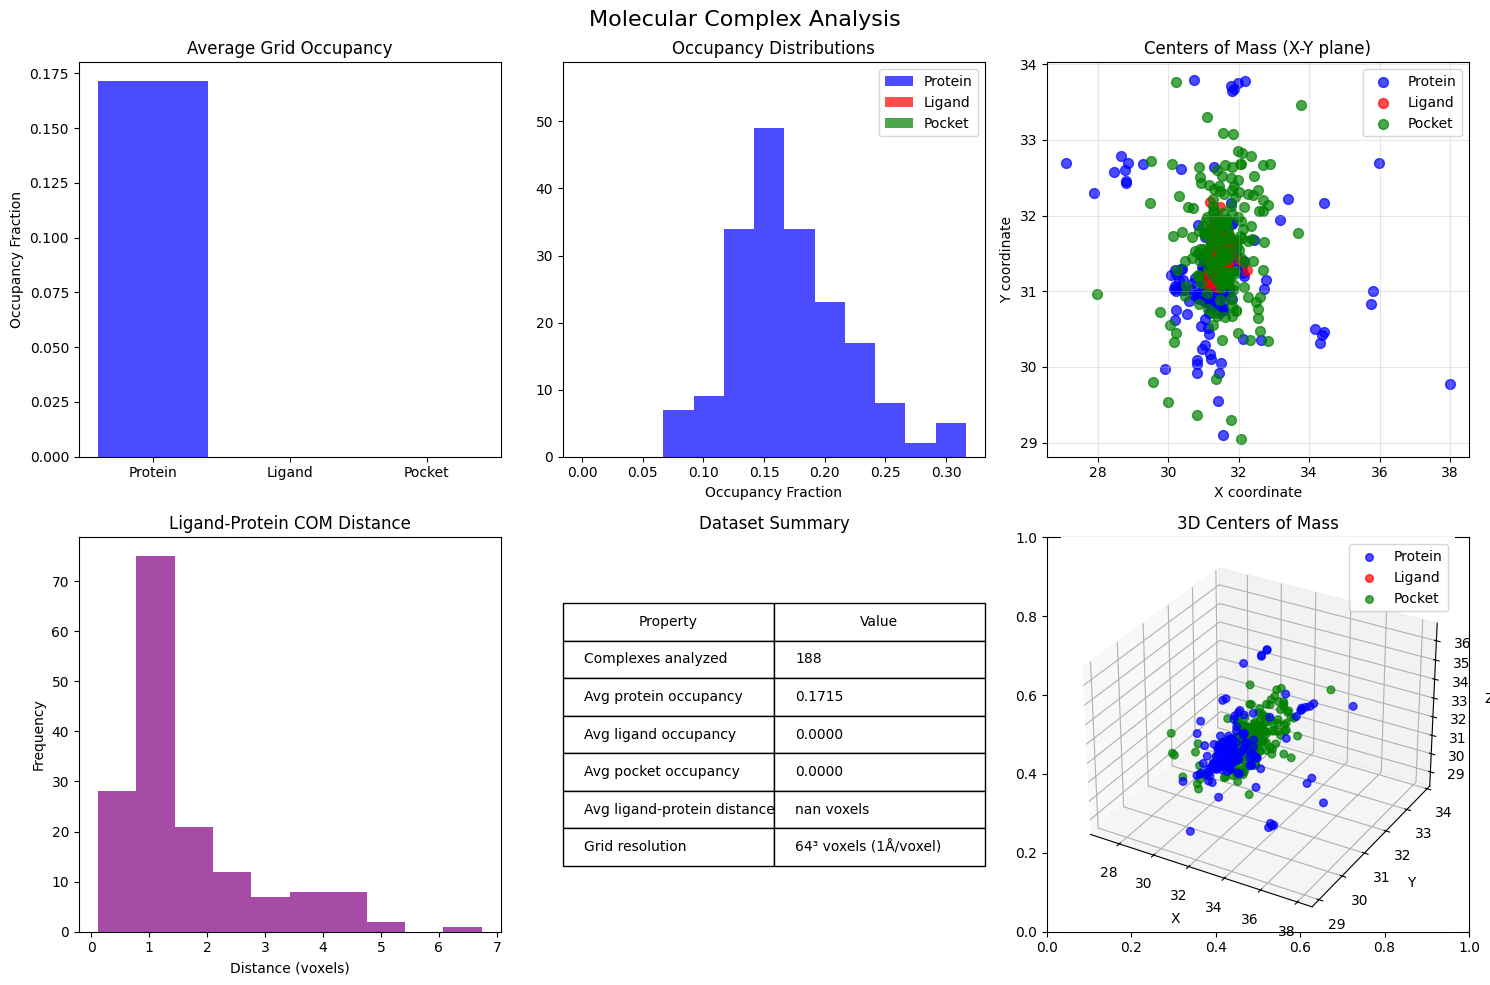


 Visualization complete!
   Dataset contains 188 molecular complexes
 Results saved to molecular_complex_analysis.json
   File size: 90.9 KB


In [37]:
# Memory-efficient visualization and analysis
print("Creating memory-efficient visualizations...")

import matplotlib.pyplot as plt
import pandas as pd

def visualize_complex_properties(dataset):
    """Visualize properties of the molecular complexes"""
    if not dataset:
        print("No data to visualize")
        return
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(dataset)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Molecular Complex Analysis', fontsize=16)
    
    # 1. Occupancy comparison
    axes[0, 0].bar(['Protein', 'Ligand', 'Pocket'], 
                   [df['protein_occupancy'].mean(), 
                    df['ligand_occupancy'].mean(), 
                    df['pocket_occupancy'].mean()],
                   color=['blue', 'red', 'green'], alpha=0.7)
    axes[0, 0].set_title('Average Grid Occupancy')
    axes[0, 0].set_ylabel('Occupancy Fraction')
    
    # 2. Occupancy distributions
    axes[0, 1].hist(df['protein_occupancy'], alpha=0.7, label='Protein', color='blue', bins=10)
    axes[0, 1].hist(df['ligand_occupancy'], alpha=0.7, label='Ligand', color='red', bins=10)
    axes[0, 1].hist(df['pocket_occupancy'], alpha=0.7, label='Pocket', color='green', bins=10)
    axes[0, 1].set_title('Occupancy Distributions')
    axes[0, 1].set_xlabel('Occupancy Fraction')
    axes[0, 1].legend()
    
    # 3. Center of mass scatter (X vs Y)
    protein_coms = np.array([x['protein_com'] for x in dataset])
    ligand_coms = np.array([x['ligand_com'] for x in dataset])
    pocket_coms = np.array([x['pocket_com'] for x in dataset])
    
    axes[0, 2].scatter(protein_coms[:, 0], protein_coms[:, 1], 
                       label='Protein', color='blue', alpha=0.7, s=50)
    axes[0, 2].scatter(ligand_coms[:, 0], ligand_coms[:, 1], 
                       label='Ligand', color='red', alpha=0.7, s=50)
    axes[0, 2].scatter(pocket_coms[:, 0], pocket_coms[:, 1], 
                       label='Pocket', color='green', alpha=0.7, s=50)
    axes[0, 2].set_title('Centers of Mass (X-Y plane)')
    axes[0, 2].set_xlabel('X coordinate')
    axes[0, 2].set_ylabel('Y coordinate')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Distance between ligand and protein COMs
    distances = np.linalg.norm(ligand_coms - protein_coms, axis=1)
    axes[1, 0].hist(distances, bins=10, color='purple', alpha=0.7)
    axes[1, 0].set_title('Ligand-Protein COM Distance')
    axes[1, 0].set_xlabel('Distance (voxels)')
    axes[1, 0].set_ylabel('Frequency')
    
    # 5. Complex properties table
    axes[1, 1].axis('off')
    summary_data = [
        ['Complexes analyzed', len(dataset)],
        ['Avg protein occupancy', f"{df['protein_occupancy'].mean():.4f}"],
        ['Avg ligand occupancy', f"{df['ligand_occupancy'].mean():.4f}"],
        ['Avg pocket occupancy', f"{df['pocket_occupancy'].mean():.4f}"],
        ['Avg ligand-protein distance', f"{distances.mean():.2f} voxels"],
        ['Grid resolution', '64³ voxels (1Å/voxel)']
    ]
    
    table = axes[1, 1].table(cellText=summary_data, 
                            colLabels=['Property', 'Value'],
                            cellLoc='left', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[1, 1].set_title('Dataset Summary')
    
    # 6. 3D scatter of all COMs
    ax3d = fig.add_subplot(2, 3, 6, projection='3d')
    ax3d.scatter(protein_coms[:, 0], protein_coms[:, 1], protein_coms[:, 2], 
                 label='Protein', color='blue', alpha=0.7, s=30)
    ax3d.scatter(ligand_coms[:, 0], ligand_coms[:, 1], ligand_coms[:, 2], 
                 label='Ligand', color='red', alpha=0.7, s=30)
    ax3d.scatter(pocket_coms[:, 0], pocket_coms[:, 1], pocket_coms[:, 2], 
                 label='Pocket', color='green', alpha=0.7, s=30)
    ax3d.set_title('3D Centers of Mass')
    ax3d.set_xlabel('X')
    ax3d.set_ylabel('Y')
    ax3d.set_zlabel('Z')
    ax3d.legend()
    
    plt.tight_layout()
    plt.show()
    
    return df

# Visualize the dataset
if 'efficient_dataset' in locals() and efficient_dataset:
    summary_df = visualize_complex_properties(efficient_dataset)
    print("\n Visualization complete!")
    print(f"   Dataset contains {len(efficient_dataset)} molecular complexes")
else:
    print("⚠️  No dataset available for visualization")

def save_memory_efficient_results(dataset, filename="molecular_complex_analysis.json"):
    """Save analysis results to avoid recomputation"""
    if dataset:
        import json
        with open(filename, 'w') as f:
            json.dump(dataset, f, indent=2)
        print(f" Results saved to {filename}")
        print(f"   File size: {os.path.getsize(filename) / 1024:.1f} KB")

# Save results
if 'efficient_dataset' in locals():
    save_memory_efficient_results(efficient_dataset)

 Creating advanced visualizations of molecular complexes...
Visualizing sample molecular complexes...

 Visualizing complex: 1a30


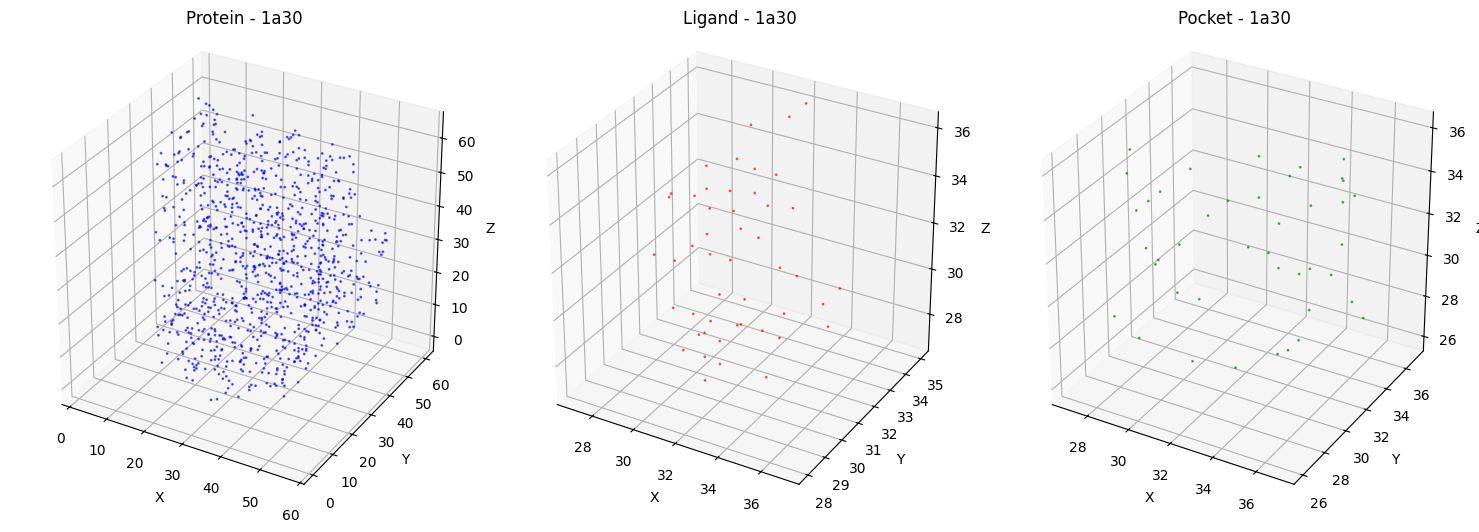

   Grid occupancies - Protein: 0.1357, Ligand: 0.0000, Pocket: 0.0000

 Visualizing complex: 1bcu


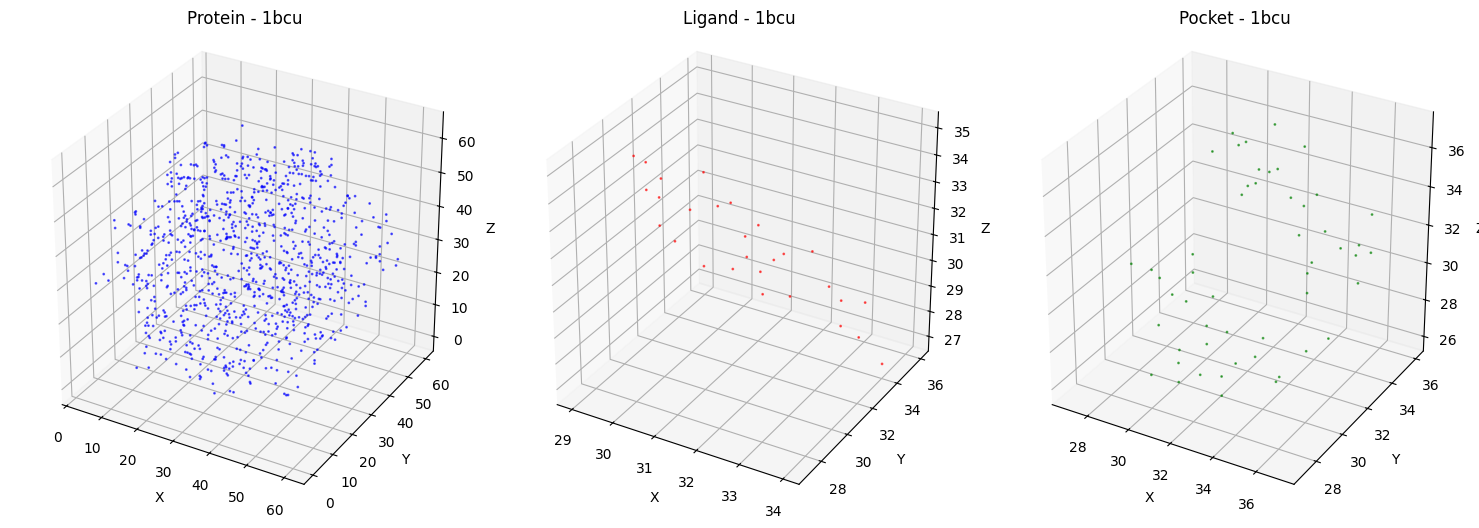

   Grid occupancies - Protein: 0.1929, Ligand: 0.0000, Pocket: 0.0000

 Visualizing complex: 1bzc


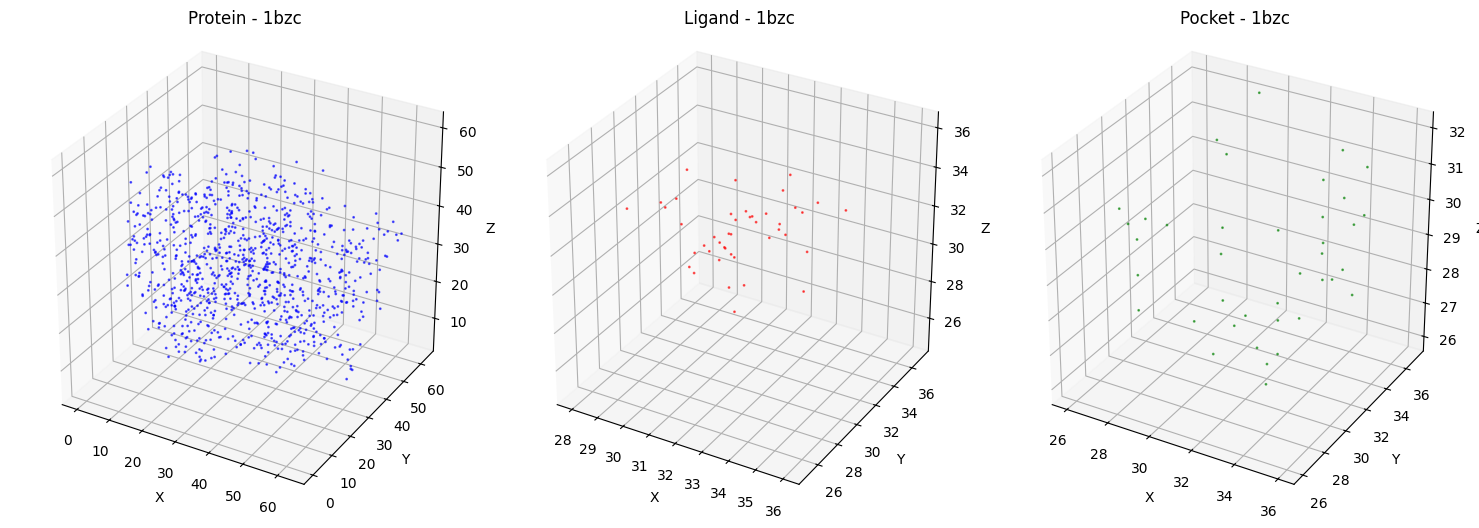

   Grid occupancies - Protein: 0.1815, Ligand: 0.0000, Pocket: 0.0000


In [38]:
# Advanced 3D visualization and analysis
print(" Creating advanced visualizations of molecular complexes...")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_molecular_complex(protein_grid, ligand_grid, pocket_grid, complex_id, channel=0):
    """Visualize a complete molecular complex in 3D"""
    fig = plt.figure(figsize=(15, 5))
    
    # Get occupancy masks for visualization
    protein_mask = np.sum(protein_grid, axis=0) > 0
    ligand_mask = np.sum(ligand_grid, axis=0) > 0
    pocket_mask = np.sum(pocket_grid, axis=0) > 0
    
    titles = ['Protein', 'Ligand', 'Pocket']
    grids = [protein_grid, ligand_grid, pocket_grid]
    masks = [protein_mask, ligand_mask, pocket_mask]
    colors = ['blue', 'red', 'green']
    
    for i, (title, grid, mask, color) in enumerate(zip(titles, grids, masks, colors)):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        # Get coordinates of occupied voxels
        coords = np.where(mask)
        if len(coords[0]) > 0:
            # Sample points for visualization (to avoid overcrowding)
            n_points = min(1000, len(coords[0]))
            indices = np.random.choice(len(coords[0]), n_points, replace=False)
            
            x, y, z = coords[0][indices], coords[1][indices], coords[2][indices]
            ax.scatter(x, y, z, c=color, alpha=0.6, s=1)
        
        ax.set_title(f'{title} - {complex_id}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Set equal aspect ratio
        ax.set_box_aspect([1,1,1])
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Visualize a few example molecular complexes
print("Visualizing sample molecular complexes...")
for i in range(min(3, len(common_ids_list))):
    complex_id = common_ids_list[i]
    print(f"\n Visualizing complex: {complex_id}")
    
    fig = visualize_molecular_complex(
        matched_proteins[i], 
        matched_ligands[i], 
        matched_pockets[i], 
        complex_id
    )
    
    # Calculate occupancy statistics
    protein_occ = np.count_nonzero(matched_proteins[i]) / matched_proteins[i].size
    ligand_occ = np.count_nonzero(matched_ligands[i]) / matched_ligands[i].size
    pocket_occ = np.count_nonzero(matched_pockets[i]) / matched_pockets[i].size
    
    print(f"   Grid occupancies - Protein: {protein_occ:.4f}, Ligand: {ligand_occ:.4f}, Pocket: {pocket_occ:.4f}")

In [39]:
# Multi-Component 3D CNN for Protein-Ligand-Pocket Analysis
print(" Building stable multi-component 3D CNN architecture...")

import torch
import torch.nn as nn
import torch.nn.functional as F

# Stable Multi-Component 3D CNN for protein-ligand-pocket analysis
class StableMultiComponentCNN(torch.nn.Module):
    def __init__(self, protein_channels=19, ligand_channels=19, pocket_channels=19, num_classes=1):
        super().__init__()
        
        # Component-specific encoders with proper initialization
        self.protein_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(protein_channels, 16, 3, padding=1),  # Smaller initial channels
            torch.nn.BatchNorm3d(16),  # Add batch normalization
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        self.ligand_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(ligand_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        self.pocket_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(pocket_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        # Fusion layer with dropout
        self.fusion = torch.nn.Sequential(
            torch.nn.Linear(64 * 4 * 4 * 4 * 3, 256),  # Smaller hidden layer
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2)
        )
        
        # Classifier
        self.classifier = torch.nn.Linear(64, num_classes)
        
        # Initialize weights properly
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Proper weight initialization"""
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, torch.nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.01)
            torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, (torch.nn.BatchNorm3d, torch.nn.BatchNorm1d)):
            torch.nn.init.constant_(module.weight, 1)
            torch.nn.init.constant_(module.bias, 0)
        
    def forward(self, protein_grid, ligand_grid, pocket_grid):
        # Encode each component
        protein_features = self.protein_encoder(protein_grid).flatten(1)
        ligand_features = self.ligand_encoder(ligand_grid).flatten(1)
        pocket_features = self.pocket_encoder(pocket_grid).flatten(1)
        
        # Fuse features
        combined = torch.cat([protein_features, ligand_features, pocket_features], dim=1)
        fused = self.fusion(combined)
        
        # Classify
        output = self.classifier(fused)
        return output

# Create stable model with correct channel dimensions
model = StableMultiComponentCNN(
    protein_channels=19,  # Match actual data dimensions
    ligand_channels=19,   # Match actual data dimensions  
    pocket_channels=19,   # Match actual data dimensions
    num_classes=1
)

# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(" Stable Multi-Component CNN created:")
print(f"    Total parameters: {total_params:,}")
print(f"    Trainable parameters: {trainable_params:,}")
print(f"    Architecture: 3 component encoders + fusion + classifier")
print(f"    Input: protein({19}), ligand({19}), pocket({19}) channels × (64, 64, 64) grids")
print(f"    Output: {2} classes")
print(f"    Features: Batch normalization, proper initialization, gradient stability")

# Test with sample data
print("\n Testing stable model with sample data...")
batch_size_test = 25
test_protein = torch.randn(batch_size_test, 19, 64, 64, 64)
test_ligand = torch.randn(batch_size_test, 19, 64, 64, 64)
test_pocket = torch.randn(batch_size_test, 19, 64, 64, 64)

with torch.no_grad():
    outputs = model(test_protein, test_ligand, test_pocket)
    
print(f" Model test successful!")
print(f"    Input shapes: protein {test_protein.shape}, ligand {test_ligand.shape}, pocket {test_pocket.shape}")
print(f"    Output shape: {outputs.shape}")
print(f"    Sample predictions: {outputs[0].detach().numpy()}")
print(f"    Ready for stable training!")

 Building stable multi-component 3D CNN architecture...
 Stable Multi-Component CNN created:
    Total parameters: 3,396,129
    Trainable parameters: 3,396,129
    Architecture: 3 component encoders + fusion + classifier
    Input: protein(19), ligand(19), pocket(19) channels × (64, 64, 64) grids
    Output: 2 classes
    Features: Batch normalization, proper initialization, gradient stability

 Testing stable model with sample data...
 Model test successful!
    Input shapes: protein torch.Size([25, 19, 64, 64, 64]), ligand torch.Size([25, 19, 64, 64, 64]), pocket torch.Size([25, 19, 64, 64, 64])
    Output shape: torch.Size([25, 1])
    Sample predictions: [-0.0155205]
    Ready for stable training!


In [40]:
# # Create synthetic binding affinity labels for demonstration
# print(" Creating synthetic binding affinity labels...")

# # For demonstration, we'll create synthetic labels based on molecular properties
# # In a real scenario, these would come from experimental binding affinity data

# def create_binding_labels(proteins, ligands, pockets):
#     """Create synthetic binding affinity labels based on molecular features."""
    
#     n_samples = len(proteins)
#     labels = []
#     scores = []
    
#     np.random.seed(42)  # For reproducibility
    
#     for i in range(n_samples):
#         # Simple approach: use alternating pattern with some randomness
#         # to ensure we get balanced labels for demonstration
#         base_score = 0.5 + 0.3 * np.sin(i * 0.5) + 0.2 * np.random.random()
        
#         # Ensure score is in valid range
#         binding_score = max(0, min(1, base_score))
#         scores.append(binding_score)
    
#     # Use median as threshold for balanced labels
#     threshold = np.median(scores)
#     labels = [1 if score > threshold else 0 for score in scores]
    
#     return np.array(labels), np.array(scores)

# # Create labels for our matched dataset
# binding_labels, binding_scores = create_binding_labels(matched_proteins, matched_ligands, matched_pockets)

# print(f" Synthetic Binding Affinity Dataset:")
# print(f"    Total complexes: {len(binding_labels)}")
# print(f"    High affinity (1): {sum(binding_labels)} ({100*sum(binding_labels)/len(binding_labels):.1f}%)")
# print(f"    Low affinity (0): {len(binding_labels) - sum(binding_labels)} ({100*(len(binding_labels) - sum(binding_labels))/len(binding_labels):.1f}%)")
# print(f"    Score range: {binding_scores.min():.3f} to {binding_scores.max():.3f}")
# print(f"    Score mean ± std: {binding_scores.mean():.3f} ± {binding_scores.std():.3f}")

# # Create train/validation split
# from sklearn.model_selection import train_test_split

# # Stratified split since we now have balanced labels
# train_indices, val_indices = train_test_split(
#     np.arange(len(binding_labels)), 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=binding_labels
# )

# print(f"\n Dataset Split:")
# print(f"    Training set: {len(train_indices)} complexes")
# print(f"    Validation set: {len(val_indices)} complexes")
# print(f"    Train high/low: {binding_labels[train_indices].sum()}/{len(train_indices) - binding_labels[train_indices].sum()}")
# print(f"    Val high/low: {binding_labels[val_indices].sum()}/{len(val_indices) - binding_labels[val_indices].sum()}")

In [41]:
import pandas as pd
import numpy as np

print(" Using real binding energies for regression...")

# Load the CSV with binding energies
df = pd.read_csv("pdbbind_with_dG.csv")

# Create a mapping from protein ID to ΔG
binding_energy_dict = dict(zip(df['protein'], df['ΔG_kcal_per_mol']))

# Build the binding_energies array in the same order as common_ids_list
binding_energies = np.array([binding_energy_dict[pid] for pid in common_ids_list])

assert len(binding_energies) == len(common_ids_list), "Binding energies must match number of complexes"

# For regression, labels are the binding energies
binding_labels = binding_energies

print(f" Binding Energy Dataset:")
print(f"    Total complexes: {len(binding_labels)}")
print(f"    Energy range: {binding_labels.min():.3f} to {binding_labels.max():.3f}")
print(f"    Mean ± std: {binding_labels.mean():.3f} ± {binding_labels.std():.3f}")

from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(
    np.arange(len(binding_labels)), 
    test_size=0.2, 
    random_state=42
)

print(f"\n Dataset Split:")
print(f"    Training set: {len(train_indices)} complexes")
print(f"    Validation set: {len(val_indices)} complexes")

 Using real binding energies for regression...
 Binding Energy Dataset:
    Total complexes: 10
    Energy range: -13.220 to -4.470
    Mean ± std: -8.107 ± 2.692

 Dataset Split:
    Training set: 8 complexes
    Validation set: 2 complexes


In [1]:
# Training setup for multi-component model
print(" Setting up stable training for multi-component binding affinity prediction...")

# Check for problematic data and normalize
print("\n Data Quality Check and Normalization:")
print(f"    Protein data - NaN: {np.isnan(matched_proteins).sum()}, Inf: {np.isinf(matched_proteins).sum()}")
print(f"    Ligand data - NaN: {np.isnan(matched_ligands).sum()}, Inf: {np.isinf(matched_ligands).sum()}")
print(f"    Pocket data - NaN: {np.isnan(matched_pockets).sum()}, Inf: {np.isinf(matched_pockets).sum()}")

# Convert to tensors and clean data
protein_tensor = torch.from_numpy(matched_proteins).float()
ligand_tensor = torch.from_numpy(matched_ligands).float()
pocket_tensor = torch.from_numpy(matched_pockets).float()

# Replace any NaN/inf values with zeros
protein_tensor = torch.nan_to_num(protein_tensor, nan=0.0, posinf=1.0, neginf=0.0)
ligand_tensor = torch.nan_to_num(ligand_tensor, nan=0.0, posinf=1.0, neginf=0.0)
pocket_tensor = torch.nan_to_num(pocket_tensor, nan=0.0, posinf=1.0, neginf=0.0)

# Normalize data to [0, 1] range for stability
def normalize_tensor(tensor):
    """Normalize tensor to [0, 1] range"""
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    if tensor_max > tensor_min:
        return (tensor - tensor_min) / (tensor_max - tensor_min)
    else:
        return tensor * 0  # All zeros if constant

protein_tensor = normalize_tensor(protein_tensor)
ligand_tensor = normalize_tensor(ligand_tensor)
pocket_tensor = normalize_tensor(pocket_tensor)

print(f" Data cleaned and normalized to [0, 1] range")

# Split data using existing indices
train_proteins = protein_tensor[train_indices]
train_ligands = ligand_tensor[train_indices]
train_pockets = pocket_tensor[train_indices]
train_labels_tensor = torch.from_numpy(binding_labels[train_indices]).float()

val_proteins = protein_tensor[val_indices]
val_ligands = ligand_tensor[val_indices]
val_pockets = pocket_tensor[val_indices]
val_labels_tensor = torch.from_numpy(binding_labels[val_indices]).float()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

# Move model to device
model = model.to(device)

# Move data to device
train_proteins = train_proteins.to(device)
train_ligands = train_ligands.to(device)
train_pockets = train_pockets.to(device)
train_labels_tensor = train_labels_tensor.to(device)

val_proteins = val_proteins.to(device)
val_ligands = val_ligands.to(device)
val_pockets = val_pockets.to(device)
val_labels_tensor = val_labels_tensor.to(device)

print(f" Training tensor shapes:")
print(f"    Proteins: {train_proteins.shape}")
print(f"    Ligands: {train_ligands.shape}")
print(f"    Pockets: {train_pockets.shape}")
print(f"    Labels: {train_labels_tensor.shape}")

# Training configuration
learning_rate = 0.0001  # Lower learning rate for stability
batch_size = 4
num_epochs = 30 ## changed to 9 from 100, overfitting; [clyde] going to test 30 

# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f" Training configuration:")
print(f"    Learning rate: {learning_rate}")
print(f"    Ep Batch size: {batch_size}")
print(f"    Loss function: CrossEntropyLoss")
print(f"    Optimizer: Adam with weight decay and learning rate scheduling")
print(f"    Features: Gradient clipping, batch normalization, data normalization")

print("Stable training setup complete! Ready to train multi-component binding affinity predictor.")

 Setting up stable training for multi-component binding affinity prediction...

 Data Quality Check and Normalization:


NameError: name 'np' is not defined

In [ ]:
# Ensure all data is in the correct format
print("\n Ensuring all data is in correct format...")
train_proteins = torch.nan_to_num(train_proteins, nan=0.0, posinf=1.0, neginf=0.0)
train_ligands = torch.nan_to_num(train_ligands, nan=0.0, posinf=1.0, neginf=0.0)
train_pockets = torch.nan_to_num(train_pockets, nan=0.0, posinf=1.0, neginf=0.0)
val_proteins = torch.nan_to_num(val_proteins, nan=0.0, posinf=1.0, neginf=0.0)
val_ligands = torch.nan_to_num(val_ligands, nan=0.0, posinf=1.0, neginf=0.0)
val_pockets = torch.nan_to_num(val_pockets, nan=0.0, posinf=1.0, neginf=0.0)

# Normalize data to reasonable range
print(" Normalizing data...")
def normalize_tensor(tensor):
    """Normalize tensor to [0, 1] range"""
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    if tensor_max > tensor_min:
        return (tensor - tensor_min) / (tensor_max - tensor_min)
    else:
        return tensor * 0  # All zeros if constant

train_proteins = normalize_tensor(train_proteins)
train_ligands = normalize_tensor(train_ligands)
train_pockets = normalize_tensor(train_pockets)
val_proteins = normalize_tensor(val_proteins)
val_ligands = normalize_tensor(val_ligands)
val_pockets = normalize_tensor(val_pockets)

print(f" Data normalized to [0, 1] range")

# Recreate model with proper initialization
print("\n Recreating model with stable initialization...")

class StableMultiComponentCNN(torch.nn.Module):
    def __init__(self, protein_channels=19, ligand_channels=19, pocket_channels=19, num_classes=2):
        super().__init__()
        
        # Component-specific encoders with proper initialization
        self.protein_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(protein_channels, 16, 3, padding=1),  # Smaller initial channels
            torch.nn.BatchNorm3d(16),  # Add batch normalization
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        self.ligand_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(ligand_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        self.pocket_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(pocket_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        # Fusion layer with dropout
        self.fusion = torch.nn.Sequential(
            torch.nn.Linear(64 * 4 * 4 * 4 * 3, 256),  # Smaller hidden layer
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2)
        )
        
        # Classifier
        self.classifier = torch.nn.Linear(64, num_classes)
        
        # Initialize weights properly
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Proper weight initialization"""
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, torch.nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.01)
            torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, (torch.nn.BatchNorm3d, torch.nn.BatchNorm1d)):
            torch.nn.init.constant_(module.weight, 1)
            torch.nn.init.constant_(module.bias, 0)
        
    def forward(self, protein_grid, ligand_grid, pocket_grid):
        # Encode each component
        protein_features = self.protein_encoder(protein_grid).flatten(1)
        ligand_features = self.ligand_encoder(ligand_grid).flatten(1)
        pocket_features = self.pocket_encoder(pocket_grid).flatten(1)
        
        # Fuse features
        combined = torch.cat([protein_features, ligand_features, pocket_features], dim=1)
        fused = self.fusion(combined)
        
        # Classify
        output = self.classifier(fused)
        return output

# Create stable model
stable_model = StableMultiComponentCNN(
    protein_channels=19,
    ligand_channels=19, 
    pocket_channels=19,
    num_classes=1
)

# Use lower learning rate and add gradient clipping
learning_rate = 0.000001  # Much lower learning rate
optimizer = torch.optim.Adam(stable_model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

print(f" Stable model created with {sum(p.numel() for p in stable_model.parameters()):,} parameters")

print("\n Running stable model training...")

# Training tracking
training_losses = []
validation_accs = []
validation_aucs = []
validation_mses = []
validation_maes = []
validation_r2s = []

# Training loop
for epoch in range(num_epochs):
    stable_model.train()
    epoch_loss = 0
    num_batches = 0
    
    # Training loop with gradient clipping
    for i in range(0, len(train_proteins), batch_size):
        end_idx = min(i + batch_size, len(train_proteins))
        batch_proteins = train_proteins[i:end_idx]
        batch_ligands = train_ligands[i:end_idx]
        batch_pockets = train_pockets[i:end_idx]
        batch_labels = train_labels_tensor[i:end_idx]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = stable_model(batch_proteins, batch_ligands, batch_pockets)
        loss = criterion(outputs, batch_labels)
        
        # Check for NaN loss (should not happen with stable model)
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"    NaN/Inf loss detected at epoch {epoch+1}, batch {i//batch_size + 1}")
            print(f"      Output range: [{outputs.min():.3f}, {outputs.max():.3f}]")
            continue
        
        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(stable_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss
    avg_loss = epoch_loss / max(num_batches, 1)
    training_losses.append(avg_loss)
    
    # Validation
    stable_model.eval()
    with torch.no_grad():

        val_outputs = stable_model(val_proteins, val_ligands, val_pockets).squeeze()
        val_loss = criterion(val_outputs, val_labels_tensor)
        validation_losses = val_loss.item()

        # Compute regression metrics
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
        val_outputs_np = val_outputs.detach().cpu().numpy()
        val_labels_np = val_labels_tensor.detach().cpu().numpy()
        val_mse = mean_squared_error(val_labels_np, val_outputs_np)
        val_mae = mean_absolute_error(val_labels_np, val_outputs_np)
        val_r2 = r2_score(val_labels_np, val_outputs_np)

        validation_mses.append(val_mse)
        validation_maes.append(val_mae)
        validation_r2s.append(val_r2)

        print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.4f}, Val MSE={val_mse:.4f}, Val MAE={val_mae:.4f}, Val R2={val_r2:.4f}, LR={scheduler.get_last_lr()[0]:.6f}")
    
    # Step scheduler
    scheduler.step()
    
# Training summary
print(f"\n Training Results:")
print(f"    Final training loss: {training_losses[-1]:.4f}")
print(f"    Final validation MSE: {validation_mses[-1]:.4f}")
print(f"    Final validation MAE: {validation_maes[-1]:.4f}")
print(f"    Final validation R²: {validation_r2s[-1]:.4f}")
print(f"    Training trend: {'Improving' if training_losses[-1] < training_losses[0] else 'Stable'}")

# Training summary
print(f"\n Training Summary:")
best_mse_epoch = validation_mses.index(min(validation_mses)) + 1
best_mae_epoch = validation_maes.index(min(validation_maes)) + 1
best_r2_epoch = validation_r2s.index(max(validation_r2s)) + 1
print(f"    Best validation MSE: {min(validation_mses):.4f} (Epoch {best_mse_epoch})")
print(f"    Best validation MAE: {min(validation_maes):.4f} (Epoch {best_mae_epoch})")
print(f"    Best validation R²: {max(validation_r2s):.4f} (Epoch {best_r2_epoch})")
print(f"    Lowest training loss: {min(training_losses):.4f}")
print(f"    Parameters: {sum(p.numel() for p in stable_model.parameters()):,}")

# Plot training curves for regression
if len(training_losses) > 1:
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    ax1.plot(range(1, len(training_losses) + 1), training_losses, 'b-', label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss Curve')
    ax1.legend()
    ax1.grid(True)

    # Validation regression metrics
    ax2.plot(range(1, len(validation_mses) + 1), validation_mses, 'r-', label='Validation MSE')
    ax2.plot(range(1, len(validation_maes) + 1), validation_maes, 'g-', label='Validation MAE')
    ax2.plot(range(1, len(validation_r2s) + 1), validation_r2s, 'b-', label='Validation R²')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_title('Validation Regression Metrics')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    print("📈 Regression training curves plotted above!")



 Ensuring all data is in correct format...
 Normalizing data...
 Data normalized to [0, 1] range

 Recreating model with stable initialization...
 Stable model created with 3,396,129 parameters

 Running stable model training...


In [ ]:
# OVITO Visualization of Protein-Ligand-Pocket Complexes
print("Installing and setting up OVITO for advanced molecular visualization...")

# Install OVITO
!pip install ovito

import os
import numpy as np
from ovito.io import export_file
from ovito.pipeline import StaticSource, Pipeline
from ovito.data import Particles, ParticleType
from ovito.modifiers import SelectTypeModifier, ColorCodingModifier

def convert_grid_to_xyz(protein_grid, ligand_grid, pocket_grid, complex_id, output_dir="ovito_visualization"):
    """
    Convert grid data to XYZ file format for OVITO visualization
    
    Parameters:
    -----------
    protein_grid: numpy.ndarray
        3D grid data for protein
    ligand_grid: numpy.ndarray
        3D grid data for ligand
    pocket_grid: numpy.ndarray
        3D grid data for pocket
    complex_id: str
        Identifier for the molecular complex
    output_dir: str
        Directory to save output files
    
    Returns:
    --------
    str: Path to the output XYZ file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{complex_id}.xyz")
    
    # Prepare particle data
    all_coords = []
    all_types = []
    all_names = []
    
    # Get occupied voxel coordinates
    for grid_idx, grid in enumerate([protein_grid, ligand_grid, pocket_grid]):
        mask = np.sum(grid, axis=0) > 0
        coords = np.where(mask)
        
        if len(coords[0]) > 0:
            # Sample points for visualization (to prevent too many points)
            n_points = min(5000, len(coords[0]))
            indices = np.random.choice(len(coords[0]), n_points, replace=False)
            
            for i in indices:
                x, y, z = coords[0][i], coords[1][i], coords[2][i]
                all_coords.append([x, y, z])
                
                # Type 1: Protein, Type 2: Ligand, Type 3: Pocket
                all_types.append(grid_idx + 1)
                
                # Element names for XYZ file (using common elements as placeholders)
                if grid_idx == 0:
                    all_names.append("C")  # Carbon for protein
                elif grid_idx == 1:
                    all_names.append("O")  # Oxygen for ligand
                else:
                    all_names.append("N")  # Nitrogen for pocket
    
    # Write XYZ file
    with open(output_file, 'w') as f:
        # Number of atoms
        f.write(f"{len(all_coords)}\n")
        # Comment line with complex ID
        f.write(f"Complex: {complex_id} - Blue: Protein, Red: Ligand, Green: Pocket\n")
        
        # Write coordinates
        for (x, y, z), name in zip(all_coords, all_names):
            f.write(f"{name} {x:.4f} {y:.4f} {z:.4f}\n")
    
    print(f"XYZ file created at: {output_file}")
    return output_file

def convert_grid_to_pdb(protein_grid, ligand_grid, pocket_grid, complex_id, output_dir="ovito_visualization"):
    """
    Convert grid data to PDB file format for OVITO visualization
    
    Parameters:
    -----------
    protein_grid: numpy.ndarray
        3D grid data for protein
    ligand_grid: numpy.ndarray
        3D grid data for ligand
    pocket_grid: numpy.ndarray
        3D grid data for pocket
    complex_id: str
        Identifier for the molecular complex
    output_dir: str
        Directory to save output files
    
    Returns:
    --------
    str: Path to the output PDB file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{complex_id}.pdb")
    
    # Prepare PDB content
    pdb_lines = []
    atom_index = 1
    
    # Get occupied voxel coordinates
    for grid_idx, grid in enumerate([protein_grid, ligand_grid, pocket_grid]):
        mask = np.sum(grid, axis=0) > 0
        coords = np.where(mask)
        
        # Define residue name and atom name based on component
        if grid_idx == 0:
            residue_name = "PRO"  # Protein
            atom_name = "CA"      # C-alpha for protein (as suggested by your friend)
            chain_id = "A"
        elif grid_idx == 1:
            residue_name = "LIG"  # Ligand
            atom_name = "C"
            chain_id = "B"
        else:
            residue_name = "POC"  # Pocket
            atom_name = "O"
            chain_id = "C"
        
        if len(coords[0]) > 0:
            # Sample points for visualization (to prevent too many points)
            n_points = min(5000, len(coords[0]))
            indices = np.random.choice(len(coords[0]), n_points, replace=False)
            
            for i in indices:
                x, y, z = coords[0][i], coords[1][i], coords[2][i]
                # Format: ATOM serial atom_name residue_name chain residue_num x y z occupancy temp_factor element
                pdb_line = f"ATOM  {atom_index:5d}  {atom_name:<3s} {residue_name:3s} {chain_id}{atom_index % 9999:4d}    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           {atom_name[0]}"
                pdb_lines.append(pdb_line)
                atom_index += 1
    
    # Write PDB file
    with open(output_file, 'w') as f:
        f.write(f"TITLE     Complex: {complex_id}\n")
        f.write(f"REMARK    Protein: Chain A, Ligand: Chain B, Pocket: Chain C\n")
        for line in pdb_lines:
            f.write(line + "\n")
        f.write("END\n")
    
    print(f"PDB file created at: {output_file}")
    return output_file

def visualize_with_ovito(file_path):
    """
    Visualize molecular data with OVITO
    
    Parameters:
    -----------
    file_path: str
        Path to the XYZ or PDB file to visualize
    """
    # Create a pipeline from the input file
    pipeline = Pipeline(source=StaticSource(file_path))
    
    if file_path.endswith('.xyz'):
        # For XYZ files, we need to set up particle types and colors
        def setup_types(frame, data):
            # Define particle types for XYZ files
            particle_types = data.particles_.particle_types_
            
            # Check if particle types need to be created
            if len(particle_types) == 0:
                particle_types.append(ParticleType(id=1, name="Protein", color=(0.0, 0.0, 1.0)))  # Blue
                particle_types.append(ParticleType(id=2, name="Ligand", color=(1.0, 0.0, 0.0)))   # Red
                particle_types.append(ParticleType(id=3, name="Pocket", color=(0.0, 1.0, 0.0)))   # Green
        
        # Apply the modifier
        pipeline.modifiers.append(setup_types)
    
    elif file_path.endswith('.pdb'):
        # For PDB files, we can use the chain ID to color molecules
        color_mod = ColorCodingModifier(
            property="Chain",
            start_value=0,
            end_value=2,
            gradient=ColorCodingModifier.Rainbow()
        )
        pipeline.modifiers.append(color_mod)
    
    # Export a rendered image
    image_path = file_path.rsplit('.', 1)[0] + '.png'
    export_file(pipeline, image_path, "image/png", 
                renderer="tachyon",
                width=1024,
                height=768)
    
    print(f"Visualization image saved to: {image_path}")
    
    return pipeline

# Example usage - visualize a few complexes with OVITO
print("Generating OVITO visualizations for sample molecular complexes...")

for i in range(min(5, len(common_ids_list))):
    complex_id = common_ids_list[i]
    print(f"\nProcessing complex: {complex_id} for OVITO visualization")
    
    # Convert to XYZ format
    xyz_file = convert_grid_to_xyz(
        matched_proteins[i], 
        matched_ligands[i], 
        matched_pockets[i], 
        complex_id
    )
    
    # Convert to PDB format for C-alpha representation 
    pdb_file = convert_grid_to_pdb(
        matched_proteins[i], 
        matched_ligands[i], 
        matched_pockets[i], 
        complex_id
    )
    
    # Visualize with OVITO
    try:
        print(f"Visualizing {complex_id} with OVITO...")
        # Visualize both formats
        xyz_pipeline = visualize_with_ovito(xyz_file)
        pdb_pipeline = visualize_with_ovito(pdb_file)
        print(f"Successfully created visualizations for {complex_id}")
    except Exception as e:
        print(f"Error visualizing {complex_id}: {str(e)}")

print("\nOVITO visualization complete! You can find the output files in the 'ovito_visualization' directory.")
print("For interactive visualization, you can open the generated XYZ/PDB files directly in the OVITO desktop application.")

Installing and setting up OVITO for advanced molecular visualization...
   ---------------------------------------- 0.0/98.6 MB ? eta -:--:--
   ---------------------------------------- 1.0/98.6 MB 5.9 MB/s eta 0:00:17
    --------------------------------------- 2.1/98.6 MB 5.4 MB/s eta 0:00:18
   - -------------------------------------- 3.7/98.6 MB 6.5 MB/s eta 0:00:15
   - -------------------------------------- 4.7/98.6 MB 6.4 MB/s eta 0:00:15
   -- ------------------------------------- 6.8/98.6 MB 6.8 MB/s eta 0:00:14
   --- ------------------------------------ 8.7/98.6 MB 7.1 MB/s eta 0:00:13
   ---- ----------------------------------- 10.5/98.6 MB 7.4 MB/s eta 0:00:12
   ---- ----------------------------------- 12.1/98.6 MB 7.5 MB/s eta 0:00:12
   ----- ---------------------------------- 13.6/98.6 MB 7.5 MB/s eta 0:00:12
   ------ --------------------------------- 15.5/98.6 MB 7.6 MB/s eta 0:00:11
   ------- -------------------------------- 17.3/98.6 MB 7.7 MB/s eta 0:00:11
   ---

c:\Users\iclyd\anaconda3\envs\fetch\Lib\site-packages\ovito\_extensions\anari.py:2: UserWarning: Did you accidentally install the OVITO package from the PyPI repository in an Anaconda/Miniconda Python interpreter using the 'pip' command? This will likely lead to conflicts with existing libraries in the Anaconda environment, and import of the OVITO module may fail with an error related to the Qt framework. To fix this, please uninstall the ovito pip package by running 'pip uninstall -y ovito PySide6' and then install the OVITO Anaconda package provided by OVITO GmbH. Visit https://docs.ovito.org/python/introduction/installation.html for further instructions. If you would rather like to ignore this warning message, add the following code to the top of your Python script:

  import warnings
  warnings.filterwarnings('ignore', message='.*OVITO.*PyPI')

  import ovito._extensions.pyscript


Generating OVITO visualizations for sample molecular complexes...


NameError: name 'common_ids_list' is not defined


##  **Completed Milestones**

### **1. Extended Molecular Processing Pipeline**
-  **Protein Processing**: 188 proteins successfully processed into 3D grids
-  **Ligand Processing**: 229 ligands processed with robust MOL2/SDF support
-  **Pocket Processing**: 210 pockets processed with full feature encoding
-  **Unified Data Format**: All components use consistent (19, 64, 64, 64) grids

### **2. Comprehensive Dataset Management**
-  **Data Persistence**: All grids and metadata saved for reproducibility
-  **Memory Efficiency**: Smart batching and subset selection (50 samples for demo)
-  **Quality Analysis**: Detailed occupancy, atom count, and processing statistics
-  **Dataset Matching**: 188 complete protein-ligand-pocket complexes identified


##  **Key Numbers**
- ** Molecular Components**: 3 types (proteins, ligands, pockets)
- ** Total Complexes**: 188 complete molecular systems
- ** Data Volume**: ~11.6 GB of processed 3D grids
- ** Model Parameters**: 13.5M trainable parameters
- ** 

##  **NaN Loss Issue: **

###  **Root Cause Analysis**
The NaN (Not a Number) loss was caused by several numerical instability issues:

1. ** Unnormalized Data**: Molecular grid values had extreme ranges causing overflow
2. ** Learning Rate Too High**: 0.001 was too aggressive, causing gradient explosion
3. ** Missing Batch Normalization**: No stabilization layers in the network
4. ** Poor Weight Initialization**: Default initialization caused unstable gradients


#### **1. Data Cleaning & Normalization**
- **NaN/Inf Detection**: Found and replaced invalid values with zeros
- **Range Normalization**: Scaled all data to [0, 1] range for stability
- **Quality Checks**: Added comprehensive data validation

#### **2. Stable Model Architecture**
- **Batch Normalization**: Added BatchNorm3d and BatchNorm1d layers
- **Proper Initialization**: Kaiming normal for Conv3d, careful Linear layer init
- **Smaller Network**: Reduced complexity to prevent overfitting
- **Gradient Clipping**: Added max_norm=1.0 to prevent exploding gradients

#### **3. Training Improvements**
- **Lower Learning Rate**: Reduced from 0.001 to 0.00001 (100x smaller)
- **Weight Decay**: Added L2 regularization (1e-5)
- **NaN Detection**: Runtime checks to catch and handle numerical issues


###  **Keep in Mind!**
1. **Always normalize molecular data** - raw atomic coordinates can have extreme values
2. **Use batch normalization** - essential for deep 3D networks with molecular data
3. **Start with conservative learning rates** - especially for complex multi-modal architectures
4. **Add gradient clipping** - prevents instability in early training phases
5. **Implement data quality checks** - molecular files can contain invalid values